# Libraries

In [144]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.image as mpimg
#from google.colab.patches import cv2_imshow
import glob 
from moviepy.editor import VideoFileClip
#import moviepy
from IPython.display import HTML
from IPython.core.display import Video
%matplotlib inline

# Camera Clibration

In [145]:
mtx = [] #newww
dist =[] #newww
    
def calibration () :
    object_points = [] # real world corners 
    img_points =[] # corners get using open cv 
    images = glob.glob('./camera_cal/*.jpg')
    
    objp = np.zeros((9*6, 3), np.float32)  # 3d object real life points 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # to make it 2d [-1 in reshape to make it flexible ]

    for f in images:
        image = cv2.imread(f);
        # Convert to grayscale image
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find chessboard corners
        ret,corners = cv2.findChessboardCorners(gray , (9,6) , None )

        if ret:
            img_points.append(corners) #the corners 
            object_points.append(objp) # the expected right corners 

        shape = (image.shape[1], image.shape[0]) # size of image 
        global mtx ; #neww
        global dist ; #neww
        ret, mtx, dist, _, _ = cv2.calibrateCamera(object_points, img_points, shape, None, None)
        
    #return mtx,dist 

def undistort(img ): #newwww  
    return cv2.undistort(img, mtx, dist, None, mtx) 

# Perspective Transfrom

In [146]:
def Perspective_Transform(img):
    #detected_image = canny(img) ; #output of canny detection 
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [100,720]
    bottom_right = [1100, 720]
    top_left = [100, 0]
    top_right = [1100, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(source, dst) 
    # M is the matrix of perspective which mutliply with original and get the wrapped image
    M_inv = cv2.getPerspectiveTransform(dst, source)
    #print(img.shape)
    #img_size = (img.shape[1], img.shape[0]) 
    #warped = cv2.warpPerspective(detected_image, M, img_size , flags=cv2.INTER_LINEAR)
    return M , M_inv

# function to get top view from front view 
def forward_perspective(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    M , _  = Perspective_Transform(img)
    return cv2.warpPerspective(img,M, img_size, flags=flags) 

# function to get front view from top view 
def backward_perspective( img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    _ , M_inv  = Perspective_Transform(img)
    return cv2.warpPerspective(img, M_inv, img_size, flags=flags)

def detected_original(img) :
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]
    # Draw lines in image by these points by red color and its closed shape 
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    #print(pts,pts.shape)
    pts = pts.reshape((-1,1,2)) # to make each point as a list
    #print(pts,pts.shape)
    copy = img.copy()
    is_closed = True        
    cv2.polylines(copy,[pts],is_closed,(255,0,0), thickness=3)  
    return copy
    

# FitLines function

In [147]:
left_fit = []
right_fit = []

def pixels_in_window(nonzerox,nonzeroy, center, margin, height):
    topleft= (center[0]-margin, center[1]-height//2)
    bottomright= (center[0]+margin, center[1]+height//2)
    condx= (topleft[0] <= nonzerox) & (nonzerox<= bottomright[0])
    condy= (topleft[1] <= nonzeroy) & (nonzeroy<= bottomright[1])
    return nonzerox[condx&condy], nonzeroy[condx&condy]

def fitlines(warped):
#     left_fit = None
#     right_fit = None
    assert(len(warped.shape) ==2)
    histogram=np.sum(warped[warped.shape[0]//2:,:],axis=0)
    #plt.imshow(histogram)
    midpoint=np.int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    leftx=[]
    lefty=[]
    rightx=[]
    righty=[]
    out_img = np.dstack((warped, warped, warped))*255
    windowsnum=9
    window_height=int(warped.shape[0]/windowsnum)
    leftx_curr=leftx_base
    rightx_curr=rightx_base
    halfWindowWidth=100
    minpix = 50
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    y_current=warped.shape[0] + window_height//2
# print(nonzero)
# print(nonzerox)
#print(nonzeroy)
# print(warped)


    for window in range(windowsnum):
        
        y_current -= window_height
        center_left = (leftx_curr, y_current)
        center_right= (rightx_curr, y_current)
        
        winYlow=warped.shape[0]-(window+1)*window_height
        winYhigh=warped.shape[0]-window*window_height
        win_xleft_low=leftx_curr-halfWindowWidth
        win_xleft_high=leftx_curr+halfWindowWidth
        win_xright_low=rightx_curr-halfWindowWidth
        win_xright_high=rightx_curr+halfWindowWidth
        cv2.rectangle(out_img,(win_xleft_low,winYlow),(win_xleft_high,winYhigh),
          (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,winYlow),(win_xright_high,winYhigh),(0,255,0), 2) 
#         good_left_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
#         good_right_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         left_lane_inds.append(good_left_inds)
#         right_lane_inds.append(good_right_inds)
        good_left_x, good_left_y =pixels_in_window(nonzerox,nonzeroy,center_left, halfWindowWidth, window_height)
        good_right_x, good_right_y =pixels_in_window(nonzerox,nonzeroy,center_right,halfWindowWidth, window_height)
        
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)  
        rightx.extend(good_right_x)
        righty.extend(good_right_y)
        
        if len(good_left_x) > minpix:
              leftx_curr = int(np.mean(good_left_x))
        if len(good_right_x) > minpix:        
              rightx_curr = int(np.mean(good_right_x))

    # print(good_left_inds)
    # print(good_right_inds)
    # print( nonzeroy,winYlow,nonzeroy >= winYlow)

#     left_lane_inds = np.concatenate(left_lane_inds)
#     right_lane_inds = np.concatenate(right_lane_inds)
#     leftx = nonzerox[left_lane_inds]
 # lefty = nonzeroy[left_lane_inds] 
#     leftx.extend(nonzerox[left_lane_inds])
#     lefty.extend(nonzeroy[left_lane_inds])
#     rightx.extend(nonzerox[right_lane_inds])
#     righty.extend(nonzeroy[right_lane_inds])
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds] 

#     if len(leftx) == 0:
#         left_fit =[]
#     else:
#         left_fit = np.polyfit(lefty, leftx, 2)
  
#     if len(rightx) == 0:
#         right_fit =[]
#     else:
#         right_fit = np.polyfit(righty, rightx, 2)
    print(len(lefty))
    print(len(righty))
    
    if len(lefty) > 1500:
        global left_fit
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(righty) > 1500:
        global right_fit
        right_fit = np.polyfit(righty, rightx, 2)
    print("left_fit",left_fit)
    
    out_img[lefty, leftx] = [255, 0, 0]   #newwwwww
    out_img[righty, rightx] = [0, 0, 255] #newwwwww
  #cv2_imshow(out_img)
    #ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    #NEWWWWWWWWWWWWWWWWWWWWW****************
    maxy = warped.shape[0] - 1
    miny = warped.shape[0] // 3
    if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

    if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

    ploty = np.linspace(miny, maxy, warped.shape[0])
#########################################################
    return out_img, lefty, leftx, righty, rightx, ploty,histogram


#Radius_of_curvature

In [148]:
def lane_curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters to obtain the real curves values
    # real object width / width in pixel
    # we assume that the lane is 3.7 * 30 m;
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 700 or 730
    
    y_eval = np.max(ploty) #the bottom point (height-1)(lowest point in picture)

    # Fit new polynomials to x,y in world space
    #make new polynomials with new values of x,y in meters

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2) #returns coeff of second order function from highest to lowest
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2) #second order because it is a curve

    # Calculate the new radii of curvature in meters to represent them
    # R=(1+(x')**2)**1.5/abs(x'');
    # equation=ax**2+bx+c, a=_fit_cr[0],b=_fit_cr[1],c=_fit_cr[2]
    # x is the value of y_eval which satisfies the equation but in meters
    # x'=2ay+b
    # x''=2a

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #take the average of the 2 curves
    radius = round((float(left_curverad) + float(right_curverad))/2.,2)

    return radius

# Draw_Lane


In [149]:
def draw_lane(warped, ploty):

    warp_zero = np.zeros_like(warped).astype(np.uint8) #make a picture like "wrap" all zeroes with type 8 bit each 0:255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) # make it an array of 3 elements
    
    #get the output of the second order equation obtained from plotted points :ax**2+bx+c
    # a=left_fit[0],b=left_fit[1],c=left_fit[2]
    #to get the x coordinates for the ploty array
    
        
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

   
    # Draw the lane onto the dark image with the array of points calculated in a prespective view
    cv2.fillPoly(color_warp, np.int_([pts]), (100,0,100)) #draw with red

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #wrap pres(src,dest,size of output);
    #newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    
    # Creating Text and set font parameters
    #TextL = "Radius of  Curvature: " + str(radius)) + " m"
    #fontScale=1.75 #factor multiplied bs the base size
    #thickness=2   
    #fontFace = cv2.FONT_HERSHEY_TRIPLEX #font type 

    # Using CV2 putText to write text into images
    #(image,text,co-ordinates of bottom left,font type,scale,colour,thickness,linetype)
    #cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    #result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return color_warp

## Calculating car postion relative to lane

In [150]:
def measure_car_position(binary_warped, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the left hand side of the center of the lane
    car_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    
    return car_pos

## Adding text to video 

In [151]:
def adding_text(final_img, car_pos):
    cv2.putText(final_img,'Car center postion to lane: '+str(car_pos)[:7]+' m',(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    return final_img

## Processing images and thresholding

In [152]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)

    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

def process_image(img):
    
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img_binary) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #new binary image 
    #plt.imshow(img, cmap='gray')
    
    # step 1:returning image in plane view
    first_detection = detected_original(img) #newwwwwwwwwwww
    un_distort = undistort(img) #newwwwwwwwwwww
   
    img1=forward_perspective(un_distort) #newwwwwwwwwwww
    
    # step 2: thresholding
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    vmin= np.min(s_channel)
    vmax= np.max(s_channel)
    
    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,:750] = 0
    
    left_lane = threshold_abs(h_channel, 20, 30)
    left_lane &= threshold_rel(v_channel, 0.7, 1.0)
    left_lane[:,550:] = 0
    img2 = left_lane | right_lane #returns warped binary images of the two lanes
    
    # step 3: detect lane edged and draw lane 
    sliding, lefty, leftx, righty, rightx, ploty,histogram=fitlines(img2)
    car_pos = measure_car_position(img2, left_fit, right_fit) #returns car pos
    img3=draw_lane(img2, ploty) 
    # step 4 : returning normal prespective black photo with drawn lane
    img4 = backward_perspective(img3)
    out_img = cv2.addWeighted(img, 1, img4, 1, 0) 
    final_out_img = adding_text(out_img,car_pos)
    
    return final_out_img 

# Test_Image 

Text(0.5, 1.0, 'Warped Image')

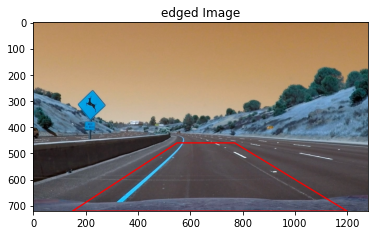

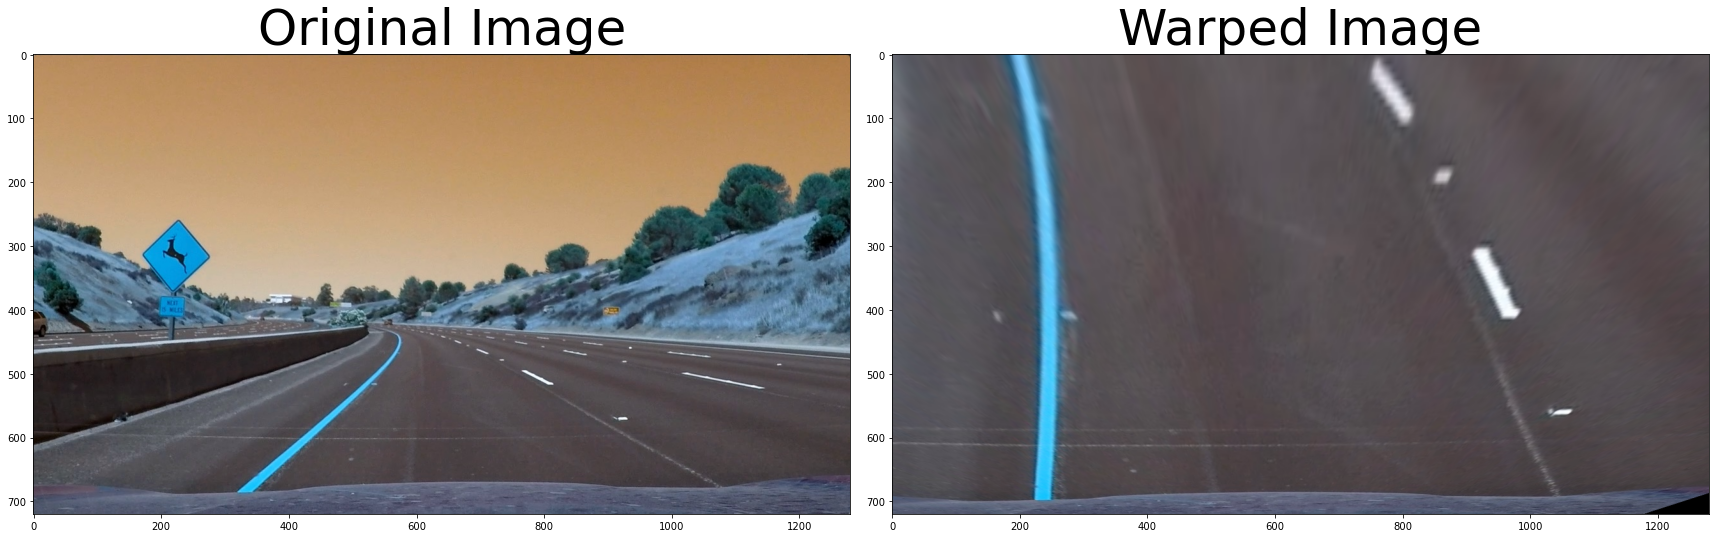

In [153]:
test_image = cv2.imread('./test_images/test2.jpg')
#warped, M_inv,edged_one = binary(test_image)
warped = forward_perspective(test_image)
edged_one = detected_original(test_image)
plt.imshow(edged_one, cmap='gray')
plt.title('edged Image')

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)

#left_fit, right_fit, out_img, lefty, leftx, righty, rightx, ploty = fitlines(warped)
#left_curverad, right_curverad = lane_curvatures(lefty, leftx, righty, rightx, ploty)
#radius = lane_curvatures(lefty, leftx, righty, rightx, ploty)
#marked_lane = draw_lane(warped, ploty)

#marked_lane = draw_lane(test_imgage, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv)

#plt.figure(figsize=(20,10))
#plt.imshow(marked_lane);

## Show test image

(720, 1280, 3)
11510
5974
left_fit [-2.07684833e-04  8.50036448e-02  2.46827190e+02]


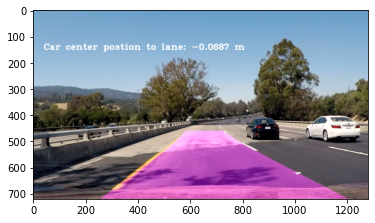

In [154]:
image = mpimg.imread('./test_images/test4.jpg')
print(image.shape)
calibration();
tmp = process_image(image)
plt.imshow(tmp)

# Save video

In [32]:
calibration(); #new 
clip = VideoFileClip("challenge_video.mp4")
out_clip = clip.fl_image(process_image)
#out_clip = clip.fl_image(process_image(mtx,dst))
#clip.preview(fps=20)
#finalVideo.write_videofile("data/output.mp4", fps=30)
out_clip.write_videofile("./vedios_out/new_challundist.mp4", audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

calibration (720, 1280, 3)
4793
2002
left_fit [ 1.43430988e-04 -5.71788141e-01  5.63796448e+02]
Moviepy - Building video ./vedios_out/new_challundist.mp4.
Moviepy - Writing video ./vedios_out/new_challundist.mp4

calibration (720, 1280, 3)
4793
2002
left_fit

t:   0%|          | 2/485 [00:00<00:33, 14.49it/s, now=None]

 [ 1.43430988e-04 -5.71788141e-01  5.63796448e+02]
calibration (720, 1280, 3)
4654
2100
left_fit [ 1.42958541e-04 -5.78156896e-01  5.66950925e+02]
calibration (720, 1280, 3)

t:   1%|          | 4/485 [00:00<00:49,  9.75it/s, now=None]


5006
2235
left_fit [ 1.46609339e-04 -5.85720989e-01  5.70716478e+02]
calibration (720, 1280, 3)
4592

t:   1%|          | 6/485 [00:00<00:51,  9.22it/s, now=None]


1810
left_fit [ 1.40266973e-04 -5.76691605e-01  5.66645467e+02]
calibration (720, 1280, 3)
5050
1242
left_fit [ 1.40937781e-04 -5.73951091e-01  5.66976669e+02]
calibration (720, 1280, 3)


t:   2%|▏         | 8/485 [00:00<00:56,  8.46it/s, now=None]

5071
629
left_fit [ 1.42983051e-04 -5.77359996e-01  5.67999604e+02]
calibration (720, 1280, 3)
9227
22590
left_fit [ 1.35805339e-04 -5.89032201e-01  5.79633401e+02]
calibration (720, 1280, 3)
9182
79381
left_fit [ 7.27669307e-05 -5.33900438e-01  5.68856126e+02]


t:   2%|▏         | 9/485 [00:01<01:08,  6.95it/s, now=None]

calibration (720, 1280, 3)
8544
57612
left_fit [ 1.26600710e-04 -5.84037543e-01  5.82888447e+02]


t:   2%|▏         | 11/485 [00:01<01:21,  5.81it/s, now=None]

calibration (720, 1280, 3)
8386
46610
left_fit [ 7.34679086e-05 -5.38471234e-01  5.76439220e+02]
calibration

t:   2%|▏         | 12/485 [00:01<01:23,  5.65it/s, now=None]

 (720, 1280, 3)
8267
53808
left_fit [ 9.57858471e-05 -5.42201796e-01  5.71916875e+02]
calibration

t:   3%|▎         | 13/485 [00:01<01:25,  5.51it/s, now=None]

 (720, 1280, 3)
8818
44797
left_fit [ 7.62726766e-05 -5.21434381e-01  5.60988552e+02]
calibration

t:   3%|▎         | 14/485 [00:02<01:19,  5.93it/s, now=None]

 (720, 1280, 3)
7506
19089
left_fit [ 9.99421742e-05 -5.34646028e-01  5.58882225e+02]
calibration (720, 1280, 3)
5907

t:   3%|▎         | 16/485 [00:02<01:07,  6.97it/s, now=None]


2799
left_fit [ 1.23273552e-04 -5.43374962e-01  5.55433084e+02]
calibration (720, 1280, 3)
4930
3045
left_fit [ 1.19589460e-04 -5.35535937e-01  5.51176869e+02]
calibration

t:   4%|▎         | 17/485 [00:02<01:04,  7.28it/s, now=None]

 (720, 1280, 3)
5137
2617
left_fit [ 9.44416258e-05 -5.11506703e-01  5.44247641e+02]
calibration (720, 1280, 3)
6046
2330
left_fit

t:   4%|▍         | 19/485 [00:02<01:01,  7.54it/s, now=None]

 [ 4.82433564e-05 -4.61390106e-01  5.29267466e+02]
calibration (720, 1280, 3)
5438
2163
left_fit [-1.06099788e-05 -3.95038743e-01  5.11274646e+02]
calibration

t:   4%|▍         | 20/485 [00:02<01:03,  7.28it/s, now=None]

 (720, 1280, 3)
5306
2363
left_fit [ 2.60092602e-05 -4.34812933e-01  5.19485945e+02]
calibration (720, 1280, 3)


t:   5%|▍         | 22/485 [00:03<00:58,  7.92it/s, now=None]

4681
2133
left_fit [ 7.50624697e-05 -4.73736080e-01  5.25670858e+02]
calibration (720, 1280, 3)
5821
2670
left_fit [ 9.07011035e-05 -4.98955263e-01  5.32866082e+02]
calibration (720, 1280, 3)


t:   5%|▍         | 24/485 [00:03<00:57,  8.08it/s, now=None]

5517
2139
left_fit [ 9.45703405e-05 -4.98547028e-01  5.31867171e+02]
calibration (720, 1280, 3)
5028
2239
left_fit [ 8.77318462e-05 -4.80764246e-01  5.21034625e+02]
calibration (720, 1280, 3)


t:   5%|▌         | 26/485 [00:03<00:55,  8.30it/s, now=None]

4501
1956
left_fit [ 9.93563860e-05 -4.98937216e-01  5.28588386e+02]
calibration (720, 1280, 3)
3757
1682
left_fit [ 9.90337167e-05 -5.01643044e-01  5.30138475e+02]
calibration (720, 1280, 3)


t:   6%|▌         | 28/485 [00:03<00:53,  8.53it/s, now=None]

5461
2797
left_fit [ 5.80162784e-05 -4.72463100e-01  5.31564430e+02]
calibration (720, 1280, 3)
5253
2930
left_fit [ 5.76084085e-05 -4.72579968e-01  5.29428738e+02]
calibration (720, 1280, 3)


t:   6%|▌         | 30/485 [00:03<00:52,  8.73it/s, now=None]

5214
3082
left_fit [ 3.95499168e-05 -4.57970982e-01  5.29218571e+02]
calibration (720, 1280, 3)
5412
3163
left_fit [ 2.95855236e-05 -4.50890236e-01  5.27578262e+02]
calibration (720, 1280, 3)


t:   7%|▋         | 32/485 [00:04<00:52,  8.68it/s, now=None]

5918
3017
left_fit [-2.95445017e-06 -4.09734026e-01  5.13476142e+02]
calibration (720, 1280, 3)
3617
3188
left_fit [-1.08074202e-04 -3.00789727e-01  4.85939429e+02]
calibration (720, 1280, 3)


t:   7%|▋         | 34/485 [00:04<00:50,  9.00it/s, now=None]

3816
2710
left_fit [-3.12619607e-05 -3.67676751e-01  4.98146899e+02]
calibration (720, 1280, 3)
3205
2818
left_fit [-1.92397160e-06 -3.81198569e-01  4.96436103e+02]
calibration (720, 1280, 3)


t:   7%|▋         | 36/485 [00:04<00:50,  8.83it/s, now=None]

4713
1578
left_fit [-3.10641606e-05 -3.44551622e-01  4.84223108e+02]
calibration (720, 1280, 3)
5935
2314
left_fit [ 2.55703850e-05 -4.00451580e-01  4.96238552e+02]
calibration (720, 1280, 3)


t:   8%|▊         | 38/485 [00:04<00:51,  8.70it/s, now=None]

4949
2078
left_fit [-4.81469660e-06 -3.76414424e-01  4.93212665e+02]
calibration (720, 1280, 3)
4401
2286
left_fit [-1.49019076e-05 -3.71326385e-01  4.94034128e+02]
calibration (720, 1280, 3)


t:   8%|▊         | 40/485 [00:05<00:51,  8.63it/s, now=None]

3858
1947
left_fit [-9.88055043e-05 -2.75435007e-01  4.67407744e+02]
calibration (720, 1280, 3)
4021
1835
left_fit [-7.29469797e-05 -2.92169216e-01  4.66342842e+02]
calibration (720, 1280, 3)


t:   9%|▊         | 42/485 [00:05<00:49,  8.91it/s, now=None]

4032
1955
left_fit [-1.46981224e-05 -3.45309927e-01  4.75599285e+02]
calibration (720, 1280, 3)
4652
2552
left_fit [ 8.50212400e-05 -4.46336768e-01  4.96271267e+02]
calibration (720, 1280, 3)


t:   9%|▉         | 44/485 [00:05<00:51,  8.53it/s, now=None]

3521
2358
left_fit [ 1.01087812e-04 -4.58950579e-01  4.96136554e+02]
calibration (720, 1280, 3)
3015
2315
left_fit [ 1.18364794e-04 -4.88291044e-01  5.07171123e+02]
calibration (720, 1280, 3)


t:   9%|▉         | 46/485 [00:05<00:52,  8.35it/s, now=None]

3049
2602
left_fit [ 1.56721551e-04 -5.41631196e-01  5.23240683e+02]
calibration (720, 1280, 3)
3113
2945
left_fit [ 1.70043539e-04 -5.69978725e-01  5.35907445e+02]
calibration

t:  10%|▉         | 47/485 [00:05<00:52,  8.28it/s, now=None]

 (720, 1280, 3)
3350
3047
left_fit [ 1.76264411e-04 -5.79169608e-01  5.34440521e+02]
calibration (720, 1280, 3)
4179

t:  10%|█         | 49/485 [00:06<00:54,  7.97it/s, now=None]


2874
left_fit [ 2.38496162e-04 -6.50831178e-01  5.52697214e+02]
calibration (720, 1280, 3)
4014
2052
left_fit [ 2.49747374e-04 -6.63490543e-01  5.54246746e+02]
calibration

t:  10%|█         | 50/485 [00:06<00:54,  8.00it/s, now=None]

 (720, 1280, 3)
3700
1759
left_fit [ 2.85673060e-04 -7.15819015e-01  5.73057799e+02]
calibration (720, 1280, 3)


t:  11%|█         | 52/485 [00:06<00:57,  7.56it/s, now=None]

4554
2171
left_fit [ 3.22215518e-04 -7.77343809e-01  5.95084058e+02]
calibration (720, 1280, 3)
3883
1966
left_fit [ 2.45125819e-04 -7.00925154e-01  5.77094293e+02]


t:  11%|█         | 53/485 [00:06<00:56,  7.61it/s, now=None]

calibration (720, 1280, 3)
3629
2063
left_fit [ 1.51733099e-04 -6.05061225e-01  5.53057446e+02]
calibration (720, 1280, 3)
3097

t:  11%|█▏        | 55/485 [00:06<00:54,  7.86it/s, now=None]


1925
left_fit [ 1.16444366e-04 -5.70580762e-01  5.45384356e+02]
calibration (720, 1280, 3)
4687
2669
left_fit [ 2.10255042e-04 -6.71770305e-01  5.68000195e+02]
calibration

t:  12%|█▏        | 56/485 [00:07<00:56,  7.65it/s, now=None]

 (720, 1280, 3)
4453
2830
left_fit [ 2.25651400e-04 -6.88182734e-01  5.72444372e+02]
calibration (720, 1280, 3)
3789

t:  12%|█▏        | 58/485 [00:07<00:56,  7.62it/s, now=None]


2810
left_fit [ 3.12049393e-04 -7.89080764e-01  6.01512118e+02]
calibration (720, 1280, 3)
3791
2873
left_fit [ 1.87117159e-04 -6.66396628e-01  5.73332311e+02]


t:  12%|█▏        | 59/485 [00:07<00:56,  7.61it/s, now=None]

calibration (720, 1280, 3)
3878
3161
left_fit [ 1.85007661e-04 -6.74470436e-01  5.79518613e+02]
calibration (720, 1280, 3)
3667

t:  13%|█▎        | 61/485 [00:07<00:54,  7.75it/s, now=None]


3243
left_fit [ 1.98336658e-04 -6.98712616e-01  5.90968850e+02]
calibration (720, 1280, 3)
3238
3142
left_fit [ 1.96558357e-04 -6.94101870e-01  5.85763030e+02]
calibration

t:  13%|█▎        | 62/485 [00:07<00:55,  7.63it/s, now=None]

 (720, 1280, 3)
3358
2645
left_fit [ 3.46038734e-04 -8.66114156e-01  6.33026246e+02]
calibration (720, 1280, 3)
2990

t:  13%|█▎        | 64/485 [00:08<00:51,  8.21it/s, now=None]


2358
left_fit [ 3.49146409e-04 -8.59756495e-01  6.26016194e+02]
calibration (720, 1280, 3)
3679
1915
left_fit [ 5.10444697e-04 -1.03698085e+00  6.75865666e+02]
calibration (720, 1280, 3)


t:  14%|█▎        | 66/485 [00:08<00:50,  8.33it/s, now=None]

5428
2477
left_fit [ 4.05949695e-04 -9.50515628e-01  6.61972857e+02]
calibration (720, 1280, 3)
5126
2542
left_fit [ 3.23272245e-04 -8.71803345e-01  6.45384220e+02]
calibration (720, 1280, 3)


t:  14%|█▍        | 68/485 [00:08<00:49,  8.51it/s, now=None]

4951
2579
left_fit [ 3.00689452e-04 -8.62144106e-01  6.49546100e+02]
calibration (720, 1280, 3)
4600
2433
left_fit [ 3.28647474e-04 -9.02583502e-01  6.66452728e+02]
calibration (720, 1280, 3)


t:  14%|█▍        | 70/485 [00:08<00:49,  8.35it/s, now=None]

3169
1937
left_fit [ 3.37710264e-04 -9.14594812e-01  6.71545417e+02]
calibration (720, 1280, 3)
2799
2549
left_fit [ 2.48344220e-04 -8.19815376e-01  6.53679691e+02]
calibration (720, 1280, 3)


t:  15%|█▍        | 72/485 [00:09<00:49,  8.42it/s, now=None]

3352
2566
left_fit [ 1.76320377e-04 -7.44969070e-01  6.35002753e+02]
calibration (720, 1280, 3)
3439
3050
left_fit [ 1.73391596e-04 -7.31053423e-01  6.30753353e+02]
calibration (720, 1280, 3)


t:  15%|█▌        | 74/485 [00:09<00:48,  8.52it/s, now=None]

3076
3043
left_fit [ 9.28361322e-05 -6.33473251e-01  6.00792646e+02]
calibration (720, 1280, 3)
3103
2960
left_fit [ 1.22571426e-04 -6.68025707e-01  6.11324318e+02]
calibration (720, 1280, 3)


t:  16%|█▌        | 76/485 [00:09<00:48,  8.43it/s, now=None]

3254
3578
left_fit [ 9.41919383e-05 -6.19622538e-01  5.93397425e+02]
calibration (720, 1280, 3)
2724
2737
left_fit [-4.98221140e-05 -4.45368406e-01  5.42771061e+02]
calibration

t:  16%|█▌        | 77/485 [00:09<00:49,  8.26it/s, now=None]

 (720, 1280, 3)
2258
2234
left_fit [-8.44838983e-05 -3.91593312e-01  5.24118912e+02]
calibration (720, 1280, 3)
2084
1714
left_fit [ 1.78824788e-04 -6.90962559e-01  6.07981389e+02]


t:  16%|█▋        | 79/485 [00:09<00:49,  8.23it/s, now=None]

calibration (720, 1280, 3)
2835
2360
left_fit [ 1.27155350e-04 -6.46911426e-01  6.01070280e+02]
calibration (720, 1280, 3)
2749
2494
left_fit

t:  17%|█▋        | 81/485 [00:10<00:48,  8.29it/s, now=None]

 [ 2.05853832e-04 -7.40446700e-01  6.30456729e+02]
calibration (720, 1280, 3)
2627
2311
left_fit [ 1.42746097e-04 -6.58159454e-01  6.04266721e+02]
calibration (720, 1280, 3)


t:  17%|█▋        | 83/485 [00:10<00:48,  8.29it/s, now=None]

2274
2155
left_fit [ 6.20423883e-05 -5.64955219e-01  5.79578097e+02]
calibration (720, 1280, 3)
2014
2295
left_fit [ 1.71946730e-04 -6.74281255e-01  6.01653959e+02]
calibration (720, 1280, 3)


t:  18%|█▊        | 85/485 [00:10<00:49,  8.14it/s, now=None]

3326
3085
left_fit [ 2.85133429e-04 -8.02642549e-01  6.35609340e+02]
calibration (720, 1280, 3)
3428
3085
left_fit [ 2.57553279e-04 -7.74138804e-01  6.27443431e+02]
calibration

t:  18%|█▊        | 86/485 [00:10<00:48,  8.17it/s, now=None]

 (720, 1280, 3)
3270
3207
left_fit [ 2.77463625e-04 -7.97706313e-01  6.35173836e+02]
calibration (720, 1280, 3)
3196

t:  18%|█▊        | 88/485 [00:10<00:48,  8.26it/s, now=None]


3457
left_fit [ 3.17046625e-04 -8.41302247e-01  6.46964487e+02]
calibration (720, 1280, 3)
2769
3412
left_fit [ 2.95764677e-04 -8.32254215e-01  6.52566001e+02]
calibration (720, 1280, 3)


t:  19%|█▊        | 90/485 [00:11<00:46,  8.55it/s, now=None]

2209
3035
left_fit [ 2.98097223e-04 -8.47534373e-01  6.62865361e+02]
calibration (720, 1280, 3)
2274
2502
left_fit [ 3.81731092e-04 -9.56023342e-01  6.97403829e+02]
calibration (720, 1280, 3)


t:  19%|█▉        | 92/485 [00:11<00:44,  8.82it/s, now=None]

2486
2137
left_fit [ 3.82138354e-04 -9.46298819e-01  6.91087777e+02]
calibration (720, 1280, 3)
2698
1900
left_fit [ 4.87469707e-04 -1.06629939e+00  7.26512074e+02]
calibration (720, 1280, 3)


t:  19%|█▉        | 94/485 [00:11<00:46,  8.47it/s, now=None]

3683
2751
left_fit [ 2.83638299e-04 -8.60480499e-01  6.77268956e+02]
calibration (720, 1280, 3)
3746
2512
left_fit [ 2.56965978e-04 -8.27104675e-01  6.66249449e+02]
calibration

t:  20%|█▉        | 95/485 [00:11<00:44,  8.69it/s, now=None]

 (720, 1280, 3)
3358
2417
left_fit [ 2.82171169e-04 -8.51630412e-01  6.71240101e+02]
calibration (720, 1280, 3)
2884
2257
left_fit [ 2.13922403e-04 -7.82578001e-01  6.59096337e+02]


t:  20%|██        | 97/485 [00:12<00:45,  8.60it/s, now=None]

calibration (720, 1280, 3)
4449
2871
left_fit [ 1.39155748e-04 -7.00777475e-01  6.41633871e+02]
calibration (720, 1280, 3)
3742
2724
left_fit

t:  20%|██        | 99/485 [00:12<00:44,  8.64it/s, now=None]

 [ 1.07633132e-04 -6.81085030e-01  6.50425116e+02]
calibration (720, 1280, 3)
3342
2934
left_fit [ 9.77460991e-05 -6.67616713e-01  6.50619877e+02]
calibration (720, 1280, 3)


t:  21%|██        | 101/485 [00:12<00:43,  8.75it/s, now=None]

2998
2825
left_fit [ 8.03051726e-05 -6.39328391e-01  6.45488199e+02]
calibration (720, 1280, 3)
3173
2844
left_fit [ 6.35454211e-05 -6.00041876e-01  6.29758012e+02]
calibration (720, 1280, 3)


t:  21%|██        | 103/485 [00:12<00:43,  8.70it/s, now=None]

3432
3226
left_fit [ 6.52897360e-05 -5.82757834e-01  6.15528426e+02]
calibration (720, 1280, 3)
3831
3433
left_fit [ 6.89200707e-05 -5.67369356e-01  6.03291605e+02]
calibration (720, 1280, 3)


t:  22%|██▏       | 105/485 [00:12<00:43,  8.69it/s, now=None]

3379
2950
left_fit [ 1.01388223e-04 -5.84277497e-01  6.01114150e+02]
calibration (720, 1280, 3)
4294
2823
left_fit [ 1.47709510e-04 -6.08750414e-01  5.96412657e+02]
calibration (720, 1280, 3)


t:  22%|██▏       | 107/485 [00:13<00:44,  8.44it/s, now=None]

4231
2095
left_fit [ 2.01584189e-04 -6.48312195e-01  5.99240642e+02]
calibration (720, 1280, 3)
5556
2863
left_fit [ 1.48583589e-04 -5.92533951e-01  5.83920643e+02]
calibration (720, 1280, 3)


t:  22%|██▏       | 109/485 [00:13<00:44,  8.44it/s, now=None]

4833
2594
left_fit [ 8.13149616e-05 -5.29194378e-01  5.68267029e+02]
calibration (720, 1280, 3)
5146
2639
left_fit [ 7.69931130e-05 -5.23671960e-01  5.66409852e+02]
calibration (720, 1280, 3)


t:  23%|██▎       | 111/485 [00:13<00:44,  8.47it/s, now=None]

4135
2315
left_fit [ 1.70496880e-04 -6.08967333e-01  5.85884362e+02]
calibration (720, 1280, 3)
5972
2700
left_fit [ 8.13701983e-05 -5.24263395e-01  5.66725683e+02]
calibration (720, 1280, 3)


t:  23%|██▎       | 113/485 [00:13<00:44,  8.35it/s, now=None]

5390
2798
left_fit [ 1.20298368e-04 -5.52942904e-01  5.71900880e+02]
calibration (720, 1280, 3)
5587
2999
left_fit [ 7.94326828e-05 -5.01582667e-01  5.54660670e+02]
calibration (720, 1280, 3)


t:  24%|██▎       | 115/485 [00:14<00:43,  8.42it/s, now=None]

4606
2862
left_fit [ 9.63167910e-05 -5.26744976e-01  5.64895424e+02]
calibration (720, 1280, 3)
4224
2710
left_fit [ 3.15139826e-05 -4.49579000e-01  5.37918341e+02]
calibration (720, 1280, 3)


t:  24%|██▍       | 117/485 [00:14<00:43,  8.40it/s, now=None]

4583
3106
left_fit [ 1.54449077e-05 -4.21899391e-01  5.26927373e+02]
calibration (720, 1280, 3)
5124
3182
left_fit [-2.58588940e-07 -3.87569093e-01  5.10223430e+02]
calibration

t:  24%|██▍       | 118/485 [00:14<00:43,  8.38it/s, now=None]

 (720, 1280, 3)
5246
2679
left_fit [ 8.00442722e-06 -3.95797268e-01  5.12243681e+02]
calibration (720, 1280, 3)
4502
1905
left_fit [ 8.12944369e-05 -4.69482749e-01  5.31771257e+02]


t:  25%|██▍       | 119/485 [00:14<00:43,  8.39it/s, now=None]

calibration (720, 1280, 3)
4368
1579
left_fit [ 1.99315014e-04 -6.06547325e-01  5.74217707e+02]
calibration (720, 1280, 3)
4359
1736
left_fit [ 3.80087100e-05 -4.45437111e-01  5.36727650e+02]


t:  25%|██▌       | 122/485 [00:14<00:42,  8.46it/s, now=None]

calibration (720, 1280, 3)
4033
1939
left_fit [ 7.42554404e-05 -4.89354734e-01  5.50522260e+02]
calibration (720, 1280, 3)
3817
1967
left_fit [ 7.82343675e-05 -4.86569499e-01  5.45872384e+02]


t:  26%|██▌       | 124/485 [00:15<00:43,  8.23it/s, now=None]

calibration (720, 1280, 3)
3905
2013
left_fit [-2.72902400e-05 -3.52593348e-01  5.03786287e+02]
calibration (720, 1280, 3)
3625

t:  26%|██▌       | 126/485 [00:15<00:43,  8.17it/s, now=None]


1981
left_fit [ 7.97363468e-05 -4.76912480e-01  5.38659952e+02]
calibration (720, 1280, 3)
3124
2043
left_fit [ 3.15656330e-05 -4.15927510e-01  5.19450079e+02]
calibration

t:  26%|██▌       | 127/485 [00:15<00:44,  7.97it/s, now=None]

 (720, 1280, 3)
2848
2189
left_fit [ 6.74043290e-05 -4.55898685e-01  5.29960097e+02]
calibration (720, 1280, 3)
2340

t:  27%|██▋       | 129/485 [00:15<00:42,  8.44it/s, now=None]


2137
left_fit [ 2.65573511e-04 -7.26645937e-01  6.21872246e+02]
calibration (720, 1280, 3)
1959
2257
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)


t:  27%|██▋       | 131/485 [00:16<00:41,  8.46it/s, now=None]

1428
2446
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
809
2346
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)


t:  27%|██▋       | 133/485 [00:16<00:41,  8.48it/s, now=None]

206
1986
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
9
1298
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)


t:  28%|██▊       | 135/485 [00:16<00:39,  8.87it/s, now=None]

223
4985
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
341
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)


t:  28%|██▊       | 137/485 [00:16<00:37,  9.22it/s, now=None]

0
742
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
828
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)


t:  29%|██▊       | 139/485 [00:16<00:34,  9.90it/s, now=None]

0
553
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
209
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0

t:  29%|██▉       | 141/485 [00:17<00:33, 10.23it/s, now=None]


371
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
540
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
363
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]


t:  29%|██▉       | 143/485 [00:17<00:33, 10.35it/s, now=None]

calibration (720, 1280, 3)
0
522
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]
calibration (720, 1280, 3)
0
4332
left_fit [ 2.32488267e-04 -6.94576811e-01  6.14250102e+02]


t:  30%|██▉       | 145/485 [00:17<00:35,  9.49it/s, now=None]

calibration (720, 1280, 3)
3900
4479
left_fit [ 3.36265386e-04 -5.74915504e-01  5.62204304e+02]
calibration (720, 1280, 3)
4133

t:  30%|███       | 147/485 [00:17<00:36,  9.14it/s, now=None]


6532
left_fit [ 2.13924730e-04 -5.34762321e-01  5.61293478e+02]
calibration (720, 1280, 3)
3821
6039
left_fit [ 1.23304311e-03 -1.09049812e+00  6.19154272e+02]
calibration (720, 1280, 3)


t:  31%|███       | 148/485 [00:17<00:38,  8.68it/s, now=None]

4780
7047
left_fit [ 1.04043275e-03 -9.91362954e-01  6.04670527e+02]
calibration (720, 1280, 3)
4321

t:  31%|███       | 150/485 [00:18<00:41,  8.03it/s, now=None]


6285
left_fit [-5.25442385e-04 -1.84738348e-01  5.12607548e+02]
calibration (720, 1280, 3)
4004
9313
left_fit [-3.03675988e-04 -2.88506214e-01  5.25149302e+02]


t:  31%|███       | 151/485 [00:18<00:42,  7.95it/s, now=None]

calibration (720, 1280, 3)
4878
5147
left_fit [-6.92201764e-05 -3.98087619e-01  5.32854561e+02]
calibration (720, 1280, 3)
8118

t:  32%|███▏      | 153/485 [00:18<00:41,  7.94it/s, now=None]


4684
left_fit [ 2.92205550e-04 -6.55387140e-01  5.80286027e+02]
calibration (720, 1280, 3)
7936
4754
left_fit [ 3.17250372e-04 -6.69305643e-01  5.83773013e+02]
calibration

t:  32%|███▏      | 154/485 [00:18<00:41,  7.90it/s, now=None]

 (720, 1280, 3)
9056
5899
left_fit [ 3.41926388e-04 -6.95675278e-01  5.90259152e+02]
calibration (720, 1280, 3)
9554


t:  32%|███▏      | 156/485 [00:18<00:41,  7.96it/s, now=None]

5221
left_fit [ 3.09694929e-04 -6.69226960e-01  5.82722667e+02]
calibration (720, 1280, 3)
9513
4713
left_fit [ 2.74591120e-04 -6.38746964e-01  5.72631727e+02]
calibration

t:  32%|███▏      | 157/485 [00:19<00:41,  7.86it/s, now=None]

 (720, 1280, 3)
9884
4921
left_fit [ 2.30000403e-04 -6.06669932e-01  5.67772221e+02]
calibration (720, 1280, 3)
8682

t:  33%|███▎      | 159/485 [00:19<00:41,  7.93it/s, now=None]


5730
left_fit [ 2.49216264e-04 -6.26165691e-01  5.71049368e+02]
calibration (720, 1280, 3)
7665
5876
left_fit [ 2.38907602e-04 -6.35707155e-01  5.79786724e+02]
calibration

t:  33%|███▎      | 160/485 [00:19<00:41,  7.80it/s, now=None]

 (720, 1280, 3)
10453
5445
left_fit [ 1.74347675e-04 -5.71023406e-01  5.62288838e+02]
calibration (720, 1280, 3)
8099

t:  33%|███▎      | 162/485 [00:19<00:40,  8.06it/s, now=None]


4914
left_fit [ 2.40409888e-04 -6.30451467e-01  5.73510457e+02]
calibration (720, 1280, 3)
7576
4428
left_fit [ 1.78665737e-04 -5.76678871e-01  5.61034732e+02]
calibration

t:  34%|███▎      | 163/485 [00:19<00:40,  7.86it/s, now=None]

 (720, 1280, 3)
6822
4259
left_fit [ 1.97682005e-04 -6.04442659e-01  5.69581505e+02]
calibration (720, 1280, 3)
6979

t:  34%|███▍      | 165/485 [00:20<00:39,  8.08it/s, now=None]


4465
left_fit [ 1.81942914e-04 -6.04179438e-01  5.74339518e+02]
calibration (720, 1280, 3)
6882
4416
left_fit [ 1.54066024e-04 -5.71477519e-01  5.63441771e+02]
calibration 

t:  34%|███▍      | 166/485 [00:20<00:39,  8.14it/s, now=None]

(720, 1280, 3)
6307
4226
left_fit [ 1.69252400e-04 -5.89712262e-01  5.68031298e+02]
calibration (720, 1280, 3)
7765
4389


t:  35%|███▍      | 168/485 [00:20<00:40,  7.79it/s, now=None]

left_fit [ 1.56044827e-04 -5.80575451e-01  5.66951562e+02]
calibration (720, 1280, 3)
6606
4425
left_fit [ 2.00053352e-04 -6.09295823e-01  5.70196358e+02]
calibration

t:  35%|███▍      | 169/485 [00:20<00:40,  7.87it/s, now=None]

 (720, 1280, 3)
6390
4296
left_fit [ 1.40065652e-04 -5.68784493e-01  5.66180902e+02]
calibration (720, 1280, 3)


t:  35%|███▌      | 171/485 [00:20<00:39,  8.04it/s, now=None]

6444
4630
left_fit [ 1.56614333e-04 -5.84616283e-01  5.71456531e+02]
calibration (720, 1280, 3)
5646
4771
left_fit [ 1.14989450e-04 -5.61581841e-01  5.75342946e+02]
calibration

t:  35%|███▌      | 172/485 [00:20<00:39,  7.95it/s, now=None]

 (720, 1280, 3)
6092
4718
left_fit [ 1.23519839e-04 -5.67184827e-01  5.76164140e+02]
calibration (720, 1280, 3)
6694

t:  36%|███▌      | 174/485 [00:21<00:39,  7.92it/s, now=None]


4014
left_fit [ 1.49450107e-04 -5.76831308e-01  5.71029755e+02]
calibration (720, 1280, 3)
5985
3526
left_fit [ 1.56634609e-04 -5.85255501e-01  5.74614778e+02]
calibration

t:  36%|███▌      | 175/485 [00:21<00:38,  8.14it/s, now=None]

 (720, 1280, 3)
6447
3161
left_fit [ 1.75790129e-04 -5.97610591e-01  5.73249295e+02]
calibration (720, 1280, 3)
6462
3587
left_fit [ 1.20944470e-04 -5.55830171e-01  5.64815935e+02]


t:  36%|███▋      | 177/485 [00:21<00:38,  7.98it/s, now=None]

calibration (720, 1280, 3)
6173
3625
left_fit [ 1.52574197e-04 -5.78514188e-01  5.65702817e+02]
calibration (720, 1280, 3)
6621

t:  37%|███▋      | 179/485 [00:21<00:37,  8.23it/s, now=None]


3864
left_fit [ 1.20589400e-04 -5.48863285e-01  5.56728332e+02]
calibration (720, 1280, 3)
5481
3724
left_fit [ 1.28612118e-04 -5.62135805e-01  5.64024875e+02]
calibration (720, 1280, 3)


t:  37%|███▋      | 181/485 [00:22<00:37,  8.06it/s, now=None]

5913
3895
left_fit [ 1.54190354e-04 -5.92128531e-01  5.71079224e+02]
calibration (720, 1280, 3)
4824
3566
left_fit [ 7.84880450e-05 -5.10811487e-01  5.49297383e+02]
calibration

t:  38%|███▊      | 182/485 [00:22<00:36,  8.20it/s, now=None]

 (720, 1280, 3)
3309
3981
left_fit [ 1.44171180e-04 -5.62824915e-01  5.55146595e+02]
calibration (720, 1280, 3)
2909
4139
left_fit [ 9.07418546e-05 -5.23071590e-01  5.52695946e+02]


t:  38%|███▊      | 184/485 [00:22<00:35,  8.49it/s, now=None]

calibration (720, 1280, 3)
2677
4083
left_fit [ 1.50270533e-04 -5.72130377e-01  5.61669976e+02]
calibration (720, 1280, 3)
2524
3981
left_fit

t:  38%|███▊      | 186/485 [00:22<00:35,  8.53it/s, now=None]

 [ 6.41270719e-05 -4.64857447e-01  5.27569549e+02]
calibration (720, 1280, 3)
2681
3766
left_fit [ 1.62031570e-04 -5.64608260e-01  5.53480787e+02]
calibration (720, 1280, 3)


t:  39%|███▉      | 188/485 [00:22<00:34,  8.55it/s, now=None]

3164
3541
left_fit [ 2.18759755e-04 -6.27956195e-01  5.70327630e+02]
calibration (720, 1280, 3)
4725
3054
left_fit [ 2.05682883e-04 -6.22852659e-01  5.71165780e+02]
calibration (720, 1280, 3)


t:  39%|███▉      | 190/485 [00:23<00:34,  8.67it/s, now=None]

4978
2664
left_fit [ 1.24137291e-04 -5.51310739e-01  5.57490594e+02]
calibration (720, 1280, 3)
4935
2491
left_fit [ 6.18951488e-05 -4.85194407e-01  5.42526270e+02]
calibration (720, 1280, 3)


t:  40%|███▉      | 192/485 [00:23<00:34,  8.57it/s, now=None]

4244
2665
left_fit [ 1.08318203e-04 -5.40040991e-01  5.58593917e+02]
calibration (720, 1280, 3)
4124
2787
left_fit [ 2.22684411e-04 -6.55619921e-01  5.84319177e+02]
calibration (720, 1280, 3)


t:  40%|████      | 194/485 [00:23<00:35,  8.18it/s, now=None]

4615
3253
left_fit [ 2.66651135e-04 -7.04802081e-01  5.96710626e+02]
calibration (720, 1280, 3)
4499
3107
left_fit [ 1.78845556e-04 -6.22167745e-01  5.78592902e+02]
calibration

t:  40%|████      | 195/485 [00:23<00:36,  8.03it/s, now=None]

 (720, 1280, 3)
3571
3106
left_fit [ 1.90105209e-04 -6.39360101e-01  5.86720457e+02]
calibration (720, 1280, 3)
3232

t:  41%|████      | 197/485 [00:23<00:33,  8.49it/s, now=None]


3141
left_fit [ 1.20416870e-04 -5.78381108e-01  5.77626300e+02]
calibration (720, 1280, 3)
3442
3276
left_fit [ 1.42830440e-04 -6.07467632e-01  5.87817580e+02]
calibration (720, 1280, 3)


t:  41%|████      | 199/485 [00:24<00:33,  8.47it/s, now=None]

3603
3546
left_fit [ 1.15142336e-04 -5.74545176e-01  5.79727963e+02]
calibration (720, 1280, 3)
3499
3564
left_fit [ 8.51844183e-05 -5.34644053e-01  5.65488524e+02]
calibration (720, 1280, 3)


t:  41%|████▏     | 201/485 [00:24<00:35,  7.96it/s, now=None]

3416
3487
left_fit [ 5.42230499e-05 -4.90949437e-01  5.51361043e+02]
calibration (720, 1280, 3)
3342
2902
left_fit [ 2.26097791e-04 -6.64213325e-01  5.94138222e+02]
calibration

t:  42%|████▏     | 202/485 [00:24<00:35,  8.09it/s, now=None]

 (720, 1280, 3)
3772
2743
left_fit [ 2.37931853e-04 -6.72455615e-01  5.94215681e+02]
calibration (720, 1280, 3)
4587
2501
left_fit [ 1.34469314e-04 -5.86087595e-01  5.77958772e+02]


t:  42%|████▏     | 204/485 [00:24<00:33,  8.28it/s, now=None]

calibration (720, 1280, 3)
3934
2665
left_fit [ 1.20070205e-04 -5.73393169e-01  5.76912862e+02]
calibration (720, 1280, 3)
4434
2543
left_fit [ 1.05342596e-04 -5.53180281e-01  5.70782087e+02]


t:  42%|████▏     | 206/485 [00:25<00:33,  8.38it/s, now=None]

calibration (720, 1280, 3)
4369
2664
left_fit [ 1.26952043e-04 -5.82774155e-01  5.81831850e+02]
calibration (720, 1280, 3)
4202
2626
left_fit [ 1.13966815e-04 -5.64572410e-01  5.75748194e+02]


t:  43%|████▎     | 208/485 [00:25<00:32,  8.40it/s, now=None]

calibration (720, 1280, 3)
3945
2653
left_fit [ 1.37894927e-04 -5.90050885e-01  5.81563960e+02]
calibration (720, 1280, 3)


t:  43%|████▎     | 210/485 [00:25<00:32,  8.59it/s, now=None]

3594
3040
left_fit [ 1.41815736e-04 -5.87163092e-01  5.76341320e+02]
calibration (720, 1280, 3)
3486
2916
left_fit [ 1.37517449e-04 -5.75282411e-01  5.66339538e+02]
calibration (720, 1280, 3)


t:  44%|████▎     | 212/485 [00:25<00:32,  8.38it/s, now=None]

3597
2948
left_fit [ 1.49984227e-04 -5.89444605e-01  5.68023177e+02]
calibration (720, 1280, 3)
3649
3348
left_fit [ 2.14820293e-04 -6.68628774e-01  5.91494323e+02]
calibration

t:  44%|████▍     | 213/485 [00:25<00:32,  8.41it/s, now=None]

 (720, 1280, 3)
3838
3320
left_fit [ 2.24738228e-04 -6.92749075e-01  6.04611251e+02]
calibration (720, 1280, 3)
3741

t:  44%|████▍     | 215/485 [00:26<00:32,  8.25it/s, now=None]


3096
left_fit [ 1.64698048e-04 -6.24728045e-01  5.85954197e+02]
calibration (720, 1280, 3)
3856
2503
left_fit [ 2.44264155e-04 -6.99149403e-01  6.00391872e+02]
calibration (720, 1280, 3)


t:  45%|████▍     | 217/485 [00:26<00:32,  8.35it/s, now=None]

4230
2138
left_fit [ 2.90509367e-04 -7.47731083e-01  6.12579523e+02]
calibration (720, 1280, 3)
4181
2383
left_fit [ 2.28006188e-04 -6.83151136e-01  5.94840674e+02]
calibration (720, 1280, 3)


t:  45%|████▌     | 219/485 [00:26<00:32,  8.22it/s, now=None]

4332
2333
left_fit [ 2.55222788e-04 -7.19136917e-01  6.06693167e+02]
calibration (720, 1280, 3)
3998
2588
left_fit [ 2.74358892e-04 -7.37604794e-01  6.11151037e+02]
calibration

t:  45%|████▌     | 220/485 [00:26<00:31,  8.36it/s, now=None]

 (720, 1280, 3)
4140
2439
left_fit [ 2.09556378e-04 -6.81169766e-01  6.03153126e+02]
calibration (720, 1280, 3)
4621
2613
left_fit [ 2.07139491e-04 -6.76328732e-01  5.99047234e+02]


t:  46%|████▌     | 222/485 [00:26<00:30,  8.51it/s, now=None]

calibration (720, 1280, 3)
4733
3081
left_fit [ 1.92685732e-04 -6.61252395e-01  5.94641119e+02]
calibration (720, 1280, 3)
4770
3077
left_fit [ 1.13969413e-04 -5.64995841e-01  5.63161408e+02]


t:  46%|████▌     | 224/485 [00:27<00:31,  8.38it/s, now=None]

calibration (720, 1280, 3)
4395
3055
left_fit [ 1.29769751e-04 -5.85590699e-01  5.68785133e+02]
calibration (720, 1280, 3)


t:  47%|████▋     | 226/485 [00:27<00:30,  8.36it/s, now=None]

4314
3398
left_fit [ 1.03754549e-04 -5.49945092e-01  5.56536129e+02]
calibration (720, 1280, 3)
4278
3512
left_fit [ 8.55846142e-05 -5.35557181e-01  5.57278136e+02]
calibration

t:  47%|████▋     | 227/485 [00:27<00:30,  8.48it/s, now=None]

 (720, 1280, 3)
4279
3537
left_fit [ 1.41942922e-04 -6.04292953e-01  5.78829233e+02]
calibration (720, 1280, 3)
3841
2952
left_fit [ 1.14784800e-04 -5.77009075e-01  5.73066472e+02]


t:  47%|████▋     | 229/485 [00:27<00:29,  8.67it/s, now=None]

calibration (720, 1280, 3)
3994
2737
left_fit [ 1.40828572e-04 -6.04445414e-01  5.81174695e+02]
calibration (720, 1280, 3)
3999

t:  48%|████▊     | 231/485 [00:27<00:29,  8.50it/s, now=None]


2267
left_fit [ 2.23337155e-04 -7.05420584e-01  6.11976043e+02]
calibration (720, 1280, 3)
4550
2414
left_fit [ 2.63858604e-04 -7.54495947e-01  6.26493146e+02]
calibration (720, 1280, 3)


t:  48%|████▊     | 233/485 [00:28<00:30,  8.37it/s, now=None]

5224
2609
left_fit [ 2.72734723e-04 -7.53294707e-01  6.20414809e+02]
calibration (720, 1280, 3)
4700
2599
left_fit [ 2.03812508e-04 -6.64704210e-01  5.89839943e+02]
calibration (720, 1280, 3)


t:  48%|████▊     | 235/485 [00:28<00:30,  8.25it/s, now=None]

4207
2116
left_fit [ 2.54133545e-04 -7.33018234e-01  6.14574671e+02]
calibration (720, 1280, 3)
4378
2451
left_fit [ 2.19161166e-04 -6.87601335e-01  5.95818913e+02]
calibration

t:  49%|████▊     | 236/485 [00:28<00:29,  8.38it/s, now=None]

 (720, 1280, 3)
4667
2661
left_fit [ 2.19361939e-04 -6.92518861e-01  5.97638332e+02]
calibration (720, 1280, 3)
4584


t:  49%|████▉     | 238/485 [00:28<00:29,  8.32it/s, now=None]

2851
left_fit [ 1.51938862e-04 -6.12079951e-01  5.74034703e+02]
calibration (720, 1280, 3)
3378
2918
left_fit [ 1.40206843e-04 -6.12971993e-01  5.81792578e+02]
calibration (720, 1280, 3)


t:  49%|████▉     | 240/485 [00:29<00:29,  8.35it/s, now=None]

3269
3031
left_fit [ 1.22357819e-04 -6.15076438e-01  5.90009811e+02]
calibration (720, 1280, 3)
3455
3249
left_fit [ 6.87072901e-05 -5.57197899e-01  5.79194938e+02]
calibration

t:  50%|████▉     | 241/485 [00:29<00:29,  8.37it/s, now=None]

 (720, 1280, 3)
3832
3456
left_fit [ 1.61306290e-04 -6.55016297e-01  6.06033378e+02]
calibration (720, 1280, 3)
4081
3028
left_fit [ 2.80070011e-04 -7.77043732e-01  6.35254251e+02]


t:  50%|█████     | 243/485 [00:29<00:29,  8.09it/s, now=None]

calibration (720, 1280, 3)
3956
2572
left_fit [ 3.50423833e-04 -8.34201536e-01  6.42872089e+02]
calibration (720, 1280, 3)
4666

t:  51%|█████     | 245/485 [00:29<00:28,  8.43it/s, now=None]


2572
left_fit [ 1.84255006e-04 -6.76652119e-01  6.08210365e+02]
calibration (720, 1280, 3)
4799
2615
left_fit [ 1.61707113e-04 -6.45752069e-01  5.96439659e+02]
calibration (720, 1280, 3)


t:  51%|█████     | 247/485 [00:29<00:28,  8.28it/s, now=None]

5247
2991
left_fit [ 1.35643874e-04 -6.17849694e-01  5.88923938e+02]
calibration (720, 1280, 3)
5670
2986
left_fit [ 1.49003564e-04 -6.22237445e-01  5.86633521e+02]
calibration

t:  51%|█████     | 248/485 [00:30<00:28,  8.40it/s, now=None]

 (720, 1280, 3)
3983
2304
left_fit [ 6.38784005e-05 -5.24156920e-01  5.61879285e+02]
calibration (720, 1280, 3)
4991

t:  52%|█████▏    | 250/485 [00:30<00:29,  8.08it/s, now=None]


3420
left_fit [ 2.02901052e-04 -6.59998612e-01  5.95218060e+02]
calibration (720, 1280, 3)
4158
3491
left_fit [ 1.16972523e-04 -5.73886208e-01  5.76711118e+02]
calibration

t:  52%|█████▏    | 251/485 [00:30<00:29,  7.85it/s, now=None]

 (720, 1280, 3)
5237
3662
left_fit [ 1.68814068e-04 -6.26350932e-01  5.88133335e+02]
calibration (720, 1280, 3)
3709

t:  52%|█████▏    | 253/485 [00:30<00:28,  8.18it/s, now=None]


3047
left_fit [ 3.65744265e-05 -4.85116502e-01  5.54294981e+02]
calibration (720, 1280, 3)
3725
3526
left_fit [ 8.79625850e-05 -5.39784401e-01  5.68584200e+02]
calibration (720, 1280, 3)


t:  53%|█████▎    | 255/485 [00:30<00:28,  8.15it/s, now=None]

3834
3527
left_fit [ 2.58987528e-05 -4.70982192e-01  5.51471048e+02]
calibration (720, 1280, 3)
4203
3372
left_fit [ 1.17246604e-04 -5.56801464e-01  5.69176326e+02]
calibration

t:  53%|█████▎    | 256/485 [00:31<00:28,  8.02it/s, now=None]

 (720, 1280, 3)
4160
2732
left_fit [ 2.20035310e-04 -6.58791177e-01  5.91225856e+02]
calibration (720, 1280, 3)
3861

t:  53%|█████▎    | 258/485 [00:31<00:28,  8.08it/s, now=None]


2343
left_fit [ 2.82409468e-04 -7.17273206e-01  6.01248844e+02]
calibration (720, 1280, 3)
5036
2602
left_fit [ 9.81935449e-05 -5.45075503e-01  5.62906025e+02]
calibration (720, 1280, 3)


t:  54%|█████▎    | 260/485 [00:31<00:27,  8.08it/s, now=None]

5496
2814
left_fit [ 1.00949382e-04 -5.54126483e-01  5.65755594e+02]
calibration (720, 1280, 3)
5267
2671
left_fit [ 9.73848427e-05 -5.49512205e-01  5.62677441e+02]
calibration

t:  54%|█████▍    | 261/485 [00:31<00:28,  7.79it/s, now=None]

 (720, 1280, 3)
4299
3061
left_fit [ 4.23360165e-05 -5.01058921e-01  5.52536704e+02]
calibration (720, 1280, 3)


t:  54%|█████▍    | 263/485 [00:31<00:27,  8.09it/s, now=None]

3959
2707
left_fit [ 1.88815219e-04 -6.39627762e-01  5.85774260e+02]
calibration (720, 1280, 3)
4773
3061
left_fit [ 1.80163254e-04 -6.43445994e-01  5.90373738e+02]
calibration (720, 1280, 3)


t:  55%|█████▍    | 265/485 [00:32<00:25,  8.59it/s, now=None]

4070
3062
left_fit [ 2.23384889e-04 -6.89262776e-01  6.05993320e+02]
calibration (720, 1280, 3)
4080
3301
left_fit [ 2.14752486e-04 -6.77870060e-01  6.02748328e+02]
calibration (720, 1280, 3)


t:  55%|█████▌    | 267/485 [00:32<00:25,  8.60it/s, now=None]

3894
3342
left_fit [ 2.60072419e-04 -7.34806245e-01  6.20074991e+02]
calibration (720, 1280, 3)
4290
3510
left_fit [ 1.53609205e-04 -5.99134150e-01  5.77115132e+02]
calibration (720, 1280, 3)


t:  55%|█████▌    | 269/485 [00:32<00:24,  8.71it/s, now=None]

3951
3920
left_fit [ 1.36004830e-04 -5.76292788e-01  5.70342537e+02]
calibration (720, 1280, 3)
3600
3505
left_fit [ 1.30542990e-04 -5.70519486e-01  5.68802402e+02]
calibration (720, 1280, 3)


t:  56%|█████▌    | 271/485 [00:32<00:25,  8.50it/s, now=None]

3678
2968
left_fit [ 2.92664695e-04 -7.43268483e-01  6.10200034e+02]
calibration (720, 1280, 3)
3319
2348
left_fit [ 4.38901737e-04 -8.99744616e-01  6.49238431e+02]
calibration 

t:  56%|█████▌    | 272/485 [00:32<00:24,  8.56it/s, now=None]

(720, 1280, 3)
4984
2993
left_fit [ 2.96959216e-04 -7.76422670e-01  6.26329656e+02]
calibration (720, 1280, 3)
3805
2405
left_fit [ 2.56751771e-04 -7.36240128e-01  6.16981877e+02]


t:  56%|█████▋    | 274/485 [00:33<00:24,  8.53it/s, now=None]

calibration (720, 1280, 3)
4120
2722
left_fit [ 2.34480351e-04 -7.23890963e-01  6.18810808e+02]
calibration (720, 1280, 3)


t:  57%|█████▋    | 276/485 [00:33<00:24,  8.61it/s, now=None]

3307
2289
left_fit [ 2.91310629e-04 -7.90884077e-01  6.39395353e+02]
calibration (720, 1280, 3)
3127
2494
left_fit [ 1.96380426e-04 -6.90287181e-01  6.15401777e+02]
calibration (720, 1280, 3)


t:  57%|█████▋    | 278/485 [00:33<00:23,  8.83it/s, now=None]

3920
3130
left_fit [ 2.54007758e-04 -7.56624974e-01  6.37152780e+02]
calibration (720, 1280, 3)
3954
3413
left_fit [ 2.42726092e-04 -7.47278166e-01  6.36910419e+02]
calibration (720, 1280, 3)


t:  58%|█████▊    | 280/485 [00:33<00:23,  8.71it/s, now=None]

3556
3109
left_fit [ 2.32098709e-04 -7.44586548e-01  6.41393270e+02]
calibration (720, 1280, 3)
2816
3060
left_fit [ 3.10293211e-04 -8.18703729e-01  6.60269737e+02]
calibration (720, 1280, 3)


t:  58%|█████▊    | 282/485 [00:34<00:23,  8.73it/s, now=None]

2255
3011
left_fit [ 2.75640953e-04 -7.76239318e-01  6.48909338e+02]
calibration (720, 1280, 3)
2208
2971
left_fit [ 2.49129282e-04 -7.44785024e-01  6.39877244e+02]
calibration (720, 1280, 3)


t:  59%|█████▊    | 284/485 [00:34<00:22,  8.78it/s, now=None]

2922
2820
left_fit [ 3.39058134e-04 -8.34348845e-01  6.59576354e+02]
calibration (720, 1280, 3)
2421
2251
left_fit [ 3.14429752e-04 -8.05202031e-01  6.50390236e+02]
calibration (720, 1280, 3)


t:  59%|█████▉    | 286/485 [00:34<00:23,  8.51it/s, now=None]

2689
1755
left_fit [ 2.53366718e-04 -7.38981235e-01  6.29673010e+02]
calibration (720, 1280, 3)
3764
2462
left_fit [ 1.91395735e-04 -6.68531990e-01  6.06803682e+02]
calibration

t:  59%|█████▉    | 287/485 [00:34<00:22,  8.74it/s, now=None]

 (720, 1280, 3)
3840
2424
left_fit [ 1.88200936e-04 -6.59784219e-01  6.00102513e+02]
calibration (720, 1280, 3)
3635
2713
left_fit [ 1.79598270e-04 -6.44147147e-01  5.91241432e+02]


t:  60%|█████▉    | 289/485 [00:34<00:22,  8.63it/s, now=None]

calibration (720, 1280, 3)
3633
2882
left_fit [ 1.77131585e-04 -6.44298604e-01  5.91148908e+02]
calibration (720, 1280, 3)


t:  60%|██████    | 291/485 [00:35<00:22,  8.48it/s, now=None]

3592
2594
left_fit [ 1.58654425e-04 -6.22325340e-01  5.84944512e+02]
calibration (720, 1280, 3)
4326
3498
left_fit [ 1.63749521e-04 -6.39692294e-01  5.95562839e+02]
calibration

t:  60%|██████    | 292/485 [00:35<00:23,  8.29it/s, now=None]

 (720, 1280, 3)
4124
3258
left_fit [ 1.64963352e-04 -6.41163320e-01  5.94941397e+02]
calibration (720, 1280, 3)
3958

t:  61%|██████    | 294/485 [00:35<00:24,  7.87it/s, now=None]


3253
left_fit [ 1.62740420e-04 -6.39143371e-01  5.98520422e+02]
calibration (720, 1280, 3)
3443
3215
left_fit [ 1.33484826e-04 -6.09200485e-01  5.93893553e+02]
calibration

t:  61%|██████    | 295/485 [00:35<00:23,  8.08it/s, now=None]

 (720, 1280, 3)
3637
3431
left_fit [ 1.51933389e-04 -6.21448207e-01  5.91403416e+02]
calibration (720, 1280, 3)
3680
3586
left_fit [ 1.74641913e-04 -6.42496277e-01  5.95424266e+02]


t:  61%|██████    | 297/485 [00:35<00:22,  8.20it/s, now=None]

calibration (720, 1280, 3)
3915
3031
left_fit [ 1.73898646e-04 -6.22351621e-01  5.82252722e+02]
calibration (720, 1280, 3)
3852
2757


t:  62%|██████▏   | 299/485 [00:36<00:22,  8.41it/s, now=None]

left_fit [ 2.26244186e-04 -6.69141144e-01  5.90690919e+02]
calibration (720, 1280, 3)
4177
2583
left_fit [ 1.82802461e-04 -6.32190730e-01  5.81503664e+02]
calibration (720, 1280, 3)


t:  62%|██████▏   | 301/485 [00:36<00:22,  8.10it/s, now=None]

3985
3130
left_fit [ 1.73757343e-04 -6.18038722e-01  5.74997214e+02]
calibration (720, 1280, 3)
5031
3214
left_fit [ 1.75833341e-04 -6.16760502e-01  5.71779770e+02]
calibration

t:  62%|██████▏   | 302/485 [00:36<00:22,  8.29it/s, now=None]

 (720, 1280, 3)
4495
2876
left_fit [ 1.51908755e-04 -5.95181208e-01  5.65056991e+02]
calibration (720, 1280, 3)
3690
2655
left_fit [ 1.44327479e-04 -5.96389583e-01  5.68927332e+02]


t:  63%|██████▎   | 304/485 [00:36<00:21,  8.59it/s, now=None]

calibration (720, 1280, 3)
5132
3583
left_fit [ 1.11296831e-04 -5.62008497e-01  5.58734565e+02]
calibration (720, 1280, 3)
4694
3429
left_fit

t:  63%|██████▎   | 306/485 [00:36<00:20,  8.76it/s, now=None]

 [ 1.14496925e-04 -5.72516839e-01  5.66512897e+02]
calibration (720, 1280, 3)
5151
3415
left_fit [ 1.24661915e-04 -5.81718290e-01  5.69241280e+02]
calibration (720, 1280, 3)


t:  64%|██████▎   | 308/485 [00:37<00:20,  8.56it/s, now=None]

4885
3318
left_fit [ 7.95322257e-05 -5.40114022e-01  5.62780451e+02]
calibration (720, 1280, 3)
4679
3525
left_fit [ 8.01320770e-05 -5.41805450e-01  5.65199927e+02]
calibration (720, 1280, 3)


t:  64%|██████▍   | 310/485 [00:37<00:20,  8.51it/s, now=None]

4056
3476
left_fit [ 1.06023413e-04 -5.60896733e-01  5.68621020e+02]
calibration (720, 1280, 3)
4267
3166
left_fit [ 1.30743450e-04 -5.77880281e-01  5.70384812e+02]
calibration (720, 1280, 3)


t:  64%|██████▍   | 312/485 [00:37<00:20,  8.28it/s, now=None]

5117
3108
left_fit [ 1.60158705e-04 -6.04686009e-01  5.75141275e+02]
calibration (720, 1280, 3)
4605
2723
left_fit [ 2.38155644e-04 -6.75657487e-01  5.90199882e+02]
calibration

t:  65%|██████▍   | 313/485 [00:37<00:21,  8.13it/s, now=None]

 (720, 1280, 3)
6153
2828
left_fit [ 1.49368414e-04 -5.85692552e-01  5.65223690e+02]
calibration (720, 1280, 3)
5657

t:  65%|██████▍   | 315/485 [00:38<00:21,  8.06it/s, now=None]


2913
left_fit [ 1.06155863e-04 -5.39217565e-01  5.51023574e+02]
calibration (720, 1280, 3)
6157
3073
left_fit [ 7.20640692e-05 -5.02445495e-01  5.40282575e+02]
calibration

t:  65%|██████▌   | 316/485 [00:38<00:20,  8.10it/s, now=None]

 (720, 1280, 3)
5905
3276
left_fit [ 1.71399674e-04 -5.94787565e-01  5.60700527e+02]
calibration (720, 1280, 3)
4222
2799


t:  66%|██████▌   | 318/485 [00:38<00:20,  8.19it/s, now=None]

left_fit [ 1.54712984e-04 -5.86450328e-01  5.62005176e+02]
calibration (720, 1280, 3)
5413
2959
left_fit [ 1.07823658e-04 -5.49887665e-01  5.57658792e+02]
calibration (720, 1280, 3)


t:  66%|██████▌   | 320/485 [00:38<00:19,  8.32it/s, now=None]

5792
3299
left_fit [ 1.11724897e-04 -5.56464239e-01  5.60175654e+02]
calibration (720, 1280, 3)
4653
3026
left_fit [ 1.12022322e-04 -5.49337969e-01  5.54340634e+02]
calibration (720, 1280, 3)


t:  66%|██████▋   | 322/485 [00:38<00:19,  8.25it/s, now=None]

4936
3563
left_fit [ 1.11143486e-04 -5.41594447e-01  5.49190816e+02]
calibration (720, 1280, 3)
4930
3779
left_fit [ 7.10797824e-05 -4.99410645e-01  5.36436331e+02]
calibration

t:  67%|██████▋   | 323/485 [00:39<00:19,  8.42it/s, now=None]

 (720, 1280, 3)
4650
3667
left_fit [ 1.04489563e-04 -5.42541016e-01  5.50321319e+02]
calibration (720, 1280, 3)
5007

t:  67%|██████▋   | 325/485 [00:39<00:18,  8.56it/s, now=None]


3659
left_fit [ 1.56808573e-04 -5.92612346e-01  5.61685924e+02]
calibration (720, 1280, 3)
5156
2947
left_fit [ 1.55900267e-04 -5.97963584e-01  5.65280688e+02]
calibration (720, 1280, 3)


t:  67%|██████▋   | 327/485 [00:39<00:19,  8.23it/s, now=None]

5004
2458
left_fit [ 1.85215262e-04 -6.33673595e-01  5.78448898e+02]
calibration (720, 1280, 3)
5635
2816
left_fit [ 7.50793282e-05 -5.25793789e-01  5.56006055e+02]
calibration

t:  68%|██████▊   | 328/485 [00:39<00:18,  8.34it/s, now=None]

 (720, 1280, 3)
6125
2580
left_fit [ 9.33063923e-05 -5.39275824e-01  5.55727808e+02]
calibration (720, 1280, 3)
6602

t:  68%|██████▊   | 329/485 [00:39<00:18,  8.26it/s, now=None]


2665
left_fit [ 4.60114058e-05 -4.96021286e-01  5.48108998e+02]
calibration (720, 1280, 3)
5731
2688
left_fit [ 4.36421490e-05 -4.91864076e-01  5.47991650e+02]
calibration (720, 1280, 3)


t:  68%|██████▊   | 332/485 [00:40<00:17,  8.53it/s, now=None]

5631
2876
left_fit [ 3.23938738e-05 -4.81164734e-01  5.47163427e+02]
calibration (720, 1280, 3)
4254
2760
left_fit [ 8.05411628e-05 -5.23717898e-01  5.60982391e+02]
calibration (720, 1280, 3)


t:  69%|██████▉   | 334/485 [00:40<00:18,  8.37it/s, now=None]

4506
3110
left_fit [ 2.68447007e-05 -4.65575356e-01  5.46082668e+02]
calibration (720, 1280, 3)
3857
3233
left_fit [ 5.62832048e-05 -4.92515714e-01  5.51560897e+02]
calibration

t:  69%|██████▉   | 335/485 [00:40<00:17,  8.48it/s, now=None]

 (720, 1280, 3)
4491
3413
left_fit [ 2.45104203e-05 -4.47427473e-01  5.34318019e+02]
calibration (720, 1280, 3)
4337
3062
left_fit [ 3.00567960e-05 -4.58910023e-01  5.38684398e+02]


t:  69%|██████▉   | 337/485 [00:40<00:17,  8.63it/s, now=None]

calibration (720, 1280, 3)
4607
3171
left_fit [-1.53096112e-06 -4.23343028e-01  5.27380908e+02]
calibration (720, 1280, 3)
5661
3875
left_fit [-5.56675308e-06 -4.11666988e-01  5.23241763e+02]


t:  70%|██████▉   | 339/485 [00:40<00:17,  8.32it/s, now=None]

calibration (720, 1280, 3)
4989
3056
left_fit [ 1.22199691e-04 -5.36977556e-01  5.53503723e+02]
calibration (720, 1280, 3)
5054

t:  70%|███████   | 341/485 [00:41<00:17,  8.21it/s, now=None]


2604
left_fit [ 1.09896929e-04 -5.18454071e-01  5.43584386e+02]
calibration (720, 1280, 3)
5572
2554
left_fit [ 4.10320946e-05 -4.56340207e-01  5.29752553e+02]
calibration

t:  71%|███████   | 342/485 [00:41<00:17,  8.37it/s, now=None]

 (720, 1280, 3)
5265
2856
left_fit [ 3.42108199e-05 -4.31837233e-01  5.15184768e+02]
calibration (720, 1280, 3)
5751
2590
left_fit [ 5.54885346e-05 -4.58703987e-01  5.22869337e+02]


t:  71%|███████   | 344/485 [00:41<00:17,  7.89it/s, now=None]

calibration (720, 1280, 3)
5309
2673
left_fit [-2.36868486e-06 -3.95991584e-01  5.08232297e+02]
calibration (720, 1280, 3)


t:  71%|███████▏  | 346/485 [00:41<00:17,  8.13it/s, now=None]

5045
2761
left_fit [-4.77766460e-06 -3.80750958e-01  4.95878292e+02]
calibration (720, 1280, 3)
5428
3100
left_fit [ 6.80119782e-05 -4.32872443e-01  4.94150252e+02]
calibration (720, 1280, 3)


t:  72%|███████▏  | 348/485 [00:42<00:16,  8.10it/s, now=None]

5778
3454
left_fit [ 3.90958379e-05 -4.10567974e-01  4.93097036e+02]
calibration (720, 1280, 3)
5093
2839
left_fit [ 3.65209894e-05 -4.14313905e-01  4.96492535e+02]
calibration

t:  72%|███████▏  | 349/485 [00:42<00:17,  7.92it/s, now=None]

 (720, 1280, 3)
4660
3090
left_fit [ 3.46384251e-05 -4.22453623e-01  5.03582981e+02]
calibration (720, 1280, 3)
4552

t:  72%|███████▏  | 351/485 [00:42<00:16,  8.09it/s, now=None]


3085
left_fit [ 4.72710426e-05 -4.14939659e-01  4.91686911e+02]
calibration (720, 1280, 3)
5103
3391
left_fit [ 1.84220882e-05 -3.92798107e-01  4.90919431e+02]
calibration (720, 1280, 3)


t:  73%|███████▎  | 353/485 [00:42<00:16,  8.22it/s, now=None]

5977
3514
left_fit [ 8.06589177e-05 -4.49889398e-01  5.02930841e+02]
calibration (720, 1280, 3)
5614
2807
left_fit [ 1.07552223e-04 -4.75270454e-01  5.09765750e+02]
calibration (720, 1280, 3)


t:  73%|███████▎  | 355/485 [00:42<00:15,  8.31it/s, now=None]

5262
2338
left_fit [ 1.38829877e-04 -5.04835345e-01  5.15436058e+02]
calibration (720, 1280, 3)
6019
2381
left_fit [ 9.33909785e-05 -4.74924418e-01  5.11111813e+02]
calibration

t:  73%|███████▎  | 356/485 [00:43<00:15,  8.32it/s, now=None]

 (720, 1280, 3)
5792
2530
left_fit [ 1.26257353e-04 -4.99978767e-01  5.14185829e+02]
calibration (720, 1280, 3)
6346
2650
left_fit [ 1.15423204e-04 -5.00252779e-01  5.19428553e+02]


t:  74%|███████▍  | 358/485 [00:43<00:15,  8.24it/s, now=None]

calibration (720, 1280, 3)
6252
2668
left_fit [ 1.16371572e-04 -4.99351370e-01  5.16575196e+02]
calibration (720, 1280, 3)
5809

t:  74%|███████▍  | 360/485 [00:43<00:15,  8.26it/s, now=None]


2705
left_fit [ 8.57149391e-05 -4.76781043e-01  5.14587462e+02]
calibration (720, 1280, 3)
5362
2958
left_fit [ 8.01823187e-05 -4.70701392e-01  5.12125981e+02]
calibration (720, 1280, 3)


t:  75%|███████▍  | 362/485 [00:43<00:15,  8.02it/s, now=None]

5842
3096
left_fit [ 6.39401455e-05 -4.69070218e-01  5.19158398e+02]
calibration (720, 1280, 3)
5022
3197
left_fit [ 4.04450592e-05 -4.41851199e-01  5.10653130e+02]
calibration

t:  75%|███████▍  | 363/485 [00:43<00:15,  7.98it/s, now=None]

 (720, 1280, 3)
4637
3153
left_fit [ 1.37503435e-05 -4.24898540e-01  5.11280214e+02]
calibration (720, 1280, 3)
4592

t:  75%|███████▌  | 365/485 [00:44<00:15,  7.86it/s, now=None]


3603
left_fit [ 3.02443408e-05 -4.28541969e-01  5.04893326e+02]
calibration (720, 1280, 3)
4331
3912
left_fit [ 1.50240402e-05 -4.11374427e-01  5.01529891e+02]


t:  75%|███████▌  | 366/485 [00:44<00:14,  8.00it/s, now=None]

calibration (720, 1280, 3)
4785
3436
left_fit [ 1.39234120e-05 -4.11850680e-01  5.02824624e+02]
calibration (720, 1280, 3)
4969

t:  76%|███████▌  | 368/485 [00:44<00:14,  8.02it/s, now=None]


2658
left_fit [ 5.12517147e-05 -4.64224930e-01  5.23097485e+02]
calibration (720, 1280, 3)
4922
2396
left_fit [-1.22923609e-05 -4.00937284e-01  5.10251458e+02]
calibration

t:  76%|███████▌  | 369/485 [00:44<00:14,  7.84it/s, now=None]

 (720, 1280, 3)
5423
2322
left_fit [ 1.77062647e-06 -4.18754435e-01  5.15110530e+02]
calibration (720, 1280, 3)
5651
2396


t:  76%|███████▋  | 371/485 [00:44<00:13,  8.18it/s, now=None]

left_fit [-2.95160942e-05 -3.83106450e-01  5.04191901e+02]
calibration (720, 1280, 3)
5497
2643
left_fit [-3.75058121e-05 -3.51216187e-01  4.83851695e+02]
calibration (720, 1280, 3)


t:  77%|███████▋  | 373/485 [00:45<00:14,  7.95it/s, now=None]

7199
3151
left_fit [-2.64509143e-05 -3.55096736e-01  4.79018962e+02]
calibration (720, 1280, 3)
7706
3415
left_fit [-2.64173415e-05 -3.53227514e-01  4.75191366e+02]


t:  77%|███████▋  | 374/485 [00:45<00:14,  7.89it/s, now=None]

calibration (720, 1280, 3)
6464
3186
left_fit [-1.29916659e-05 -3.62860551e-01  4.73639462e+02]
calibration (720, 1280, 3)
6012
3358
left_fit [-1.46489049e-05 -3.60021544e-01  4.73064790e+02]


t:  78%|███████▊  | 376/485 [00:45<00:13,  8.16it/s, now=None]

calibration (720, 1280, 3)
5487
3274
left_fit [-1.62755405e-05 -3.47873370e-01  4.65239600e+02]
calibration (720, 1280, 3)
5549
3816
left_fit

t:  78%|███████▊  | 378/485 [00:45<00:12,  8.42it/s, now=None]

 [ 2.24091456e-05 -3.87713226e-01  4.75106797e+02]
calibration (720, 1280, 3)
5080
3758
left_fit [ 4.65586047e-05 -4.04264139e-01  4.74927315e+02]
calibration (720, 1280, 3)


t:  78%|███████▊  | 380/485 [00:45<00:12,  8.30it/s, now=None]

4741
3620
left_fit [ 4.07979041e-05 -4.01571840e-01  4.76440422e+02]
calibration (720, 1280, 3)
4080
3041
left_fit [ 8.04093600e-05 -4.29457271e-01  4.77386124e+02]
calibration

t:  79%|███████▊  | 381/485 [00:46<00:12,  8.29it/s, now=None]

 (720, 1280, 3)
3995
2406
left_fit [ 1.45679946e-04 -5.00534481e-01  4.95936569e+02]
calibration (720, 1280, 3)
3661
1711
left_fit [ 4.90172554e-05 -4.08699791e-01  4.72628870e+02]


t:  79%|███████▉  | 383/485 [00:46<00:12,  8.37it/s, now=None]

calibration (720, 1280, 3)
5231
2849
left_fit [ 6.13270605e-05 -4.20226364e-01  4.70936275e+02]
calibration (720, 1280, 3)
5246

t:  79%|███████▉  | 385/485 [00:46<00:12,  8.25it/s, now=None]


3138
left_fit [ 6.62182581e-05 -4.36294831e-01  4.77731184e+02]
calibration (720, 1280, 3)
5100
3110
left_fit [ 5.58297628e-05 -4.23201656e-01  4.70195919e+02]
calibration (720, 1280, 3)


t:  80%|███████▉  | 387/485 [00:46<00:12,  8.12it/s, now=None]

4685
3067
left_fit [ 1.00847773e-04 -4.75966739e-01  4.87267365e+02]
calibration (720, 1280, 3)
4986
3197
left_fit [ 7.32279685e-05 -4.56882006e-01  4.86721648e+02]
calibration

t:  80%|████████  | 388/485 [00:46<00:12,  7.97it/s, now=None]

 (720, 1280, 3)
4453
3072
left_fit [ 6.17936289e-05 -4.47425119e-01  4.85881223e+02]
calibration (720, 1280, 3)


t:  80%|████████  | 390/485 [00:47<00:12,  7.74it/s, now=None]

4320
3361
left_fit [ 7.50159261e-05 -4.67781666e-01  4.90760065e+02]
calibration (720, 1280, 3)
4154
3700
left_fit [ 7.30212376e-05 -4.58909817e-01  4.82406072e+02]
calibration

t:  81%|████████  | 391/485 [00:47<00:12,  7.69it/s, now=None]

 (720, 1280, 3)
4446
3603
left_fit [ 2.17045873e-05 -4.03233322e-01  4.64821335e+02]
calibration (720, 1280, 3)
4521
3374


t:  81%|████████  | 393/485 [00:47<00:12,  7.47it/s, now=None]

left_fit [ 2.39483313e-05 -4.12866100e-01  4.67679751e+02]
calibration (720, 1280, 3)
4527
3395
left_fit [ 1.68934970e-05 -4.12015124e-01  4.70397342e+02]


t:  81%|████████  | 394/485 [00:47<00:12,  7.16it/s, now=None]

calibration (720, 1280, 3)
4347
2813
left_fit [ 1.48638852e-05 -4.14700805e-01  4.73959155e+02]
calibration (720, 1280, 3)


t:  82%|████████▏ | 396/485 [00:48<00:12,  7.25it/s, now=None]

4876
2520
left_fit [ 9.59533521e-05 -4.92288241e-01  4.88891964e+02]
calibration (720, 1280, 3)
5218
2212
left_fit [ 7.76492590e-05 -4.96227764e-01  4.99326730e+02]
calibration

t:  82%|████████▏ | 397/485 [00:48<00:11,  7.51it/s, now=None]

 (720, 1280, 3)
6356
2760
left_fit [ 6.51340429e-05 -4.80558280e-01  4.92054168e+02]
calibration (720, 1280, 3)
6154

t:  82%|████████▏ | 399/485 [00:48<00:11,  7.43it/s, now=None]


2415
left_fit [ 4.92781029e-05 -4.74945017e-01  4.95443469e+02]
calibration (720, 1280, 3)
4526
2695
left_fit [ 8.23366643e-05 -5.10777743e-01  5.08294356e+02]


t:  82%|████████▏ | 400/485 [00:48<00:11,  7.31it/s, now=None]

calibration (720, 1280, 3)
5341
2769
left_fit [ 5.39372721e-05 -4.96201340e-01  5.14947679e+02]
calibration (720, 1280, 3)
4589

t:  83%|████████▎ | 402/485 [00:48<00:11,  7.42it/s, now=None]


2852
left_fit [ 7.43984275e-05 -5.24602384e-01  5.24992857e+02]
calibration (720, 1280, 3)
5874
3139
left_fit [ 2.45883920e-05 -4.74732509e-01  5.11326158e+02]
calibration

t:  83%|████████▎ | 403/485 [00:48<00:11,  7.36it/s, now=None]

 (720, 1280, 3)
5705
3305
left_fit [ 3.30035854e-05 -4.62532083e-01  4.99085790e+02]
calibration (720, 1280, 3)
5354

t:  84%|████████▎ | 405/485 [00:49<00:10,  7.62it/s, now=None]


3521
left_fit [-2.82145764e-05 -4.01351535e-01  4.86200141e+02]
calibration (720, 1280, 3)
5742
3685
left_fit [ 1.68664128e-05 -4.56495214e-01  5.03126388e+02]
calibration

t:  84%|████████▎ | 406/485 [00:49<00:10,  7.68it/s, now=None]

 (720, 1280, 3)
3965
3572
left_fit [ 1.11600974e-04 -5.52375056e-01  5.33390572e+02]
calibration (720, 1280, 3)
4632

t:  84%|████████▍ | 408/485 [00:49<00:09,  8.05it/s, now=None]


3037
left_fit [ 3.13230428e-05 -4.85054472e-01  5.26138870e+02]
calibration (720, 1280, 3)
4422
2343
left_fit [ 2.81888148e-05 -4.90348504e-01  5.33816116e+02]
calibration (720, 1280, 3)


t:  85%|████████▍ | 410/485 [00:49<00:09,  8.04it/s, now=None]

4098
1755
left_fit [ 1.13289777e-04 -5.88219678e-01  5.69942917e+02]
calibration (720, 1280, 3)
4439
1953
left_fit [ 1.18739344e-04 -5.68349143e-01  5.52127797e+02]
calibration (720, 1280, 3)


t:  85%|████████▍ | 412/485 [00:50<00:08,  8.32it/s, now=None]

5145
2010
left_fit [ 1.42356691e-04 -5.88564319e-01  5.54412411e+02]
calibration (720, 1280, 3)
4561
2238
left_fit [ 1.28914830e-04 -5.57620496e-01  5.37717118e+02]
calibration (720, 1280, 3)


t:  85%|████████▌ | 414/485 [00:50<00:08,  8.13it/s, now=None]

5463
2463
left_fit [ 9.70066115e-05 -5.37233089e-01  5.35493822e+02]
calibration (720, 1280, 3)
4808
2656
left_fit [ 1.66864039e-04 -5.99798857e-01  5.50120459e+02]
calibration

t:  86%|████████▌ | 415/485 [00:50<00:08,  8.17it/s, now=None]

 (720, 1280, 3)
4410
2263
left_fit [ 8.25967984e-05 -5.31060937e-01  5.40639111e+02]
calibration (720, 1280, 3)
5371
2798
left_fit

t:  86%|████████▌ | 417/485 [00:50<00:08,  8.33it/s, now=None]

 [ 7.76099673e-05 -5.41347466e-01  5.53130216e+02]
calibration (720, 1280, 3)
5491
2732
left_fit [ 6.34099021e-05 -5.25723338e-01  5.50328961e+02]
calibration (720, 1280, 3)


t:  86%|████████▋ | 419/485 [00:50<00:07,  8.50it/s, now=None]

5287
2968
left_fit [ 7.70942409e-05 -5.35752736e-01  5.51632348e+02]
calibration (720, 1280, 3)
4958
3032
left_fit [ 5.77100760e-05 -5.14954359e-01  5.48338370e+02]
calibration (720, 1280, 3)


t:  87%|████████▋ | 421/485 [00:51<00:07,  8.35it/s, now=None]

4246
2868
left_fit [ 8.08599635e-05 -5.45106219e-01  5.59382751e+02]
calibration (720, 1280, 3)
4353
2777
left_fit [ 3.99412092e-05 -4.96087257e-01  5.45324979e+02]
calibration (720, 1280, 3)


t:  87%|████████▋ | 423/485 [00:51<00:07,  8.34it/s, now=None]

3661
2565
left_fit [ 2.64194104e-04 -7.00497422e-01  5.90641504e+02]
calibration (720, 1280, 3)
5260
3081
left_fit [ 5.99730397e-05 -4.88608859e-01  5.32343248e+02]
calibration (720, 1280, 3)


t:  88%|████████▊ | 425/485 [00:51<00:07,  8.18it/s, now=None]

4684
2455
left_fit [-2.27687530e-05 -3.96047128e-01  5.05053386e+02]
calibration (720, 1280, 3)
5120
2378
left_fit [-2.46161430e-05 -3.89770805e-01  5.02326288e+02]
calibration (720, 1280, 3)


t:  88%|████████▊ | 427/485 [00:51<00:06,  8.35it/s, now=None]

5107
2478
left_fit [-5.02715395e-05 -3.66396127e-01  5.00419398e+02]
calibration (720, 1280, 3)
4888
2589
left_fit [ 1.22377582e-05 -4.30951691e-01  5.19474280e+02]
calibration (720, 1280, 3)


t:  88%|████████▊ | 429/485 [00:52<00:06,  8.17it/s, now=None]

2687
1540
left_fit [-8.55229475e-05 -3.28496835e-01  4.95806404e+02]
calibration (720, 1280, 3)
2912
1587
left_fit [-4.87088145e-05 -3.67230611e-01  5.09439899e+02]
calibration (720, 1280, 3)


t:  89%|████████▉ | 431/485 [00:52<00:06,  8.45it/s, now=None]

4321
2658
left_fit [ 4.20848213e-05 -4.70414545e-01  5.39064607e+02]
calibration (720, 1280, 3)
4786
2972
left_fit [ 6.04347686e-05 -4.67862939e-01  5.27494684e+02]
calibration (720, 1280, 3)


t:  89%|████████▉ | 433/485 [00:52<00:06,  8.27it/s, now=None]

3926
2714
left_fit [ 6.36523065e-05 -4.63756613e-01  5.21933042e+02]
calibration (720, 1280, 3)
4412
3119
left_fit [ 7.95409452e-06 -4.04317038e-01  5.05205351e+02]
calibration

t:  89%|████████▉ | 434/485 [00:52<00:06,  8.33it/s, now=None]

 (720, 1280, 3)
4249
3514
left_fit [-1.62491664e-05 -3.74925839e-01  4.93492821e+02]
calibration (720, 1280, 3)
3602
2958
left_fit [-4.32946404e-05 -3.38780219e-01  4.81315783e+02]


t:  90%|████████▉ | 436/485 [00:52<00:05,  8.53it/s, now=None]

calibration (720, 1280, 3)
4422
2822
left_fit [-9.13159344e-06 -3.68883142e-01  4.84639208e+02]
calibration (720, 1280, 3)
3881

t:  90%|█████████ | 438/485 [00:53<00:05,  8.16it/s, now=None]


1924
left_fit [ 3.88143599e-05 -4.28871728e-01  5.05182694e+02]
calibration (720, 1280, 3)
6385
2897
left_fit [-6.59966238e-05 -3.22669089e-01  4.80528577e+02]
calibration (720, 1280, 3)


t:  91%|█████████ | 440/485 [00:53<00:05,  7.88it/s, now=None]

5636
2753
left_fit [-4.20000827e-05 -3.45451320e-01  4.87587201e+02]
calibration (720, 1280, 3)
6282
2875
left_fit [-5.80375059e-05 -3.16765862e-01  4.73523722e+02]
calibration

t:  91%|█████████ | 441/485 [00:53<00:05,  7.59it/s, now=None]

 (720, 1280, 3)
5580
2731
left_fit [-8.93378213e-05 -2.91633191e-01  4.72770987e+02]
calibration (720, 1280, 3)
5176

t:  91%|█████████▏| 443/485 [00:53<00:05,  7.73it/s, now=None]


2904
left_fit [-8.29631174e-05 -2.82706590e-01  4.62723361e+02]
calibration (720, 1280, 3)
6334
3180
left_fit [-7.74193431e-05 -2.88240898e-01  4.63238007e+02]


t:  92%|█████████▏| 444/485 [00:54<00:05,  7.66it/s, now=None]

calibration (720, 1280, 3)
6478
2902
left_fit [-7.25092196e-05 -2.89994106e-01  4.63104542e+02]
calibration (720, 1280, 3)


t:  92%|█████████▏| 446/485 [00:54<00:05,  7.77it/s, now=None]

6180
2952
left_fit [-7.51951050e-05 -2.92907901e-01  4.68215693e+02]
calibration (720, 1280, 3)
4871
2792
left_fit [-1.02535418e-04 -2.60495118e-01  4.61474264e+02]
calibration

t:  92%|█████████▏| 447/485 [00:54<00:04,  7.82it/s, now=None]

 (720, 1280, 3)
5179
3136
left_fit [-1.07746299e-04 -2.54195524e-01  4.64017068e+02]
calibration (720, 1280, 3)
4002

t:  93%|█████████▎| 449/485 [00:54<00:04,  7.99it/s, now=None]


2752
left_fit [-9.83285129e-05 -2.66060615e-01  4.69442253e+02]
calibration (720, 1280, 3)
4776
2964
left_fit [-9.43584185e-05 -2.62279601e-01  4.68176666e+02]
calibration

t:  93%|█████████▎| 450/485 [00:54<00:04,  7.90it/s, now=None]

 (720, 1280, 3)
4218
2200
left_fit [-3.52988574e-05 -3.18655264e-01  4.81179400e+02]
calibration (720, 1280, 3)
4932

t:  93%|█████████▎| 452/485 [00:55<00:04,  7.87it/s, now=None]


1726
left_fit [-3.38581913e-05 -3.05313501e-01  4.74239751e+02]
calibration (720, 1280, 3)
5854
2282
left_fit [-1.33606484e-04 -2.10983116e-01  4.53244161e+02]
calibration

t:  93%|█████████▎| 453/485 [00:55<00:04,  7.62it/s, now=None]

 (720, 1280, 3)
5522
2272
left_fit [-1.34356983e-04 -1.99914394e-01  4.47719837e+02]
calibration (720, 1280, 3)


t:  94%|█████████▍| 455/485 [00:55<00:03,  7.70it/s, now=None]

6026
2785
left_fit [-1.11759280e-04 -2.16096196e-01  4.50101093e+02]
calibration (720, 1280, 3)
6728
2786
left_fit [-1.16340350e-04 -2.04812628e-01  4.44014521e+02]
calibration (720, 1280, 3)


t:  94%|█████████▍| 457/485 [00:55<00:03,  7.67it/s, now=None]

6470
2671
left_fit [-1.11304692e-04 -2.02447222e-01  4.38502931e+02]
calibration (720, 1280, 3)
7235
3065
left_fit [-1.00834227e-04 -2.09423790e-01  4.38690107e+02]
calibration

t:  94%|█████████▍| 458/485 [00:55<00:03,  7.90it/s, now=None]

 (720, 1280, 3)
6738
2581
left_fit [-1.18988130e-04 -1.93576654e-01  4.35947096e+02]
calibration (720, 1280, 3)


t:  95%|█████████▍| 460/485 [00:56<00:03,  7.97it/s, now=None]

6434
2620
left_fit [-1.28658440e-04 -1.83721779e-01  4.34955947e+02]
calibration (720, 1280, 3)
5788
2637
left_fit [-1.03078747e-04 -2.10552364e-01  4.43889660e+02]
calibration (720, 1280, 3)


t:  95%|█████████▌| 462/485 [00:56<00:02,  8.07it/s, now=None]

5059
2422
left_fit [-1.10665853e-04 -2.05180491e-01  4.43570736e+02]
calibration (720, 1280, 3)
5780
2801
left_fit [-1.11420602e-04 -1.95340790e-01  4.37143153e+02]
calibration

t:  95%|█████████▌| 463/485 [00:56<00:02,  8.05it/s, now=None]

 (720, 1280, 3)
5504
2313
left_fit [-1.21895806e-04 -1.84178101e-01  4.33954487e+02]
calibration (720, 1280, 3)
5554

t:  96%|█████████▌| 465/485 [00:56<00:02,  8.03it/s, now=None]


2105
left_fit [-1.21602532e-04 -1.78334894e-01  4.29284168e+02]
calibration (720, 1280, 3)
6723
1384
left_fit [-1.09312593e-04 -1.85361857e-01  4.27924202e+02]
calibration

t:  96%|█████████▌| 466/485 [00:56<00:02,  8.00it/s, now=None]

 (720, 1280, 3)
8684
3197
left_fit [-1.23156960e-04 -1.76236890e-01  4.25900275e+02]
calibration (720, 1280, 3)
8319

t:  96%|█████████▋| 468/485 [00:57<00:02,  7.79it/s, now=None]


2927
left_fit [-9.87827301e-05 -1.95908405e-01  4.27595672e+02]
calibration (720, 1280, 3)
7499
2538
left_fit [-7.49576546e-05 -2.21422672e-01  4.35823183e+02]
calibration

t:  97%|█████████▋| 469/485 [00:57<00:02,  7.87it/s, now=None]

 (720, 1280, 3)
6291
1987
left_fit [-9.23093808e-05 -2.05823037e-01  4.34639292e+02]
calibration (720, 1280, 3)
6852
2461


t:  97%|█████████▋| 471/485 [00:57<00:01,  7.69it/s, now=None]

left_fit [-6.32216086e-05 -2.33449629e-01  4.40770279e+02]
calibration (720, 1280, 3)
8145
2694
left_fit [-7.20418249e-05 -2.20531488e-01  4.36860343e+02]
calibration

t:  97%|█████████▋| 472/485 [00:57<00:01,  7.83it/s, now=None]

 (720, 1280, 3)
5025
1480
left_fit [-8.02048974e-05 -2.06522771e-01  4.31169603e+02]
calibration (720, 1280, 3)
7003
2732
left_fit

t:  98%|█████████▊| 474/485 [00:57<00:01,  7.92it/s, now=None]

 [-5.88504195e-05 -2.33136747e-01  4.39378985e+02]
calibration (720, 1280, 3)
6107
2571
left_fit [-4.96720125e-05 -2.37115834e-01  4.35748376e+02]
calibration (720, 1280, 3)


t:  98%|█████████▊| 476/485 [00:58<00:01,  8.12it/s, now=None]

5177
2162
left_fit [-1.46437108e-04 -1.28856191e-01  4.03326605e+02]
calibration (720, 1280, 3)
5030
2088
left_fit [-1.20666807e-04 -1.58134864e-01  4.12527714e+02]
calibration (720, 1280, 3)


t:  99%|█████████▊| 478/485 [00:58<00:00,  8.14it/s, now=None]

4164
1716
left_fit [-1.80150423e-04 -9.01508448e-02  3.94037761e+02]
calibration (720, 1280, 3)
4727
1234
left_fit [-5.97346491e-05 -2.25631843e-01  4.33296963e+02]
calibration (720, 1280, 3)


t:  99%|█████████▉| 479/485 [00:58<00:00,  8.26it/s, now=None]

5042
673
left_fit [-1.95676692e-05 -2.77893636e-01  4.50338750e+02]
calibration (720, 1280, 3)
9565

t:  99%|█████████▉| 481/485 [00:58<00:00,  7.85it/s, now=None]


3275
left_fit [-7.35832967e-05 -2.33356513e-01  4.43907043e+02]
calibration (720, 1280, 3)
9206
3223
left_fit [-9.65312495e-05 -2.20114405e-01  4.45471723e+02]
calibration

t:  99%|█████████▉| 482/485 [00:58<00:00,  7.70it/s, now=None]

 (720, 1280, 3)
9596
3096
left_fit [-4.84407042e-05 -2.72449774e-01  4.58030657e+02]
calibration (720, 1280, 3)


t: 100%|█████████▉| 484/485 [00:59<00:00,  7.55it/s, now=None]

8080
2945
left_fit [-6.18990392e-05 -2.61605371e-01  4.57180664e+02]
calibration (720, 1280, 3)
6788
2889
left_fit [-8.69687958e-05 -2.27543751e-01  4.44856480e+02]


t: 100%|██████████| 485/485 [00:59<00:00,  7.47it/s, now=None]

calibration (720, 1280, 3)
7499
2665
left_fit [-6.23786168e-05 -2.51998636e-01  4.50062534e+02]
calibration (720, 1280, 3)
7499


2665
left_fit [-6.23786168e-05 -2.51998636e-01  4.50062534e+02]
Moviepy - Done !
Moviepy - video ready ./vedios_out/new_challundist.mp4


# Video

In [ ]:
#import numpy as np
#import cv2
#from google.colab.patches import cv2_imshow #if not using colab delete this line
cap = cv2.VideoCapture('project_video.mp4') #enter the url of the video
while(cap.isOpened()):
  ret, frame = cap.read() #the frame is like the image
  #print(ret)
  #if ret == True:
   # out = process_image(frame);
    #warped, M_inv,edged_one = binary(frame)
    # Display the resulting frame19
    #cv2.imshow('Frame',out)
  ###################code edge detection ################################
  #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

########################end of code##############################
  #cv2_imshow(gray) # if not using collab make the function : cv2.imshaow("title",gray)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


0
4879
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5093
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5317
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5574
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5003
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4194
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3299
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2185
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2488
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2585
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2203
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2846
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4515
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4755
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4613
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4949
lef

0
2597
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2784
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4172
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4551
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4885
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3995
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3528
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2694
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
1652
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2154
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2211
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2497
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2700
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4185
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2979
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4430
lef

0
4532
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4867
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4415
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3678
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2823
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
1719
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2171
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2232
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2384
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2573
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2700
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
2888
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3081
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4875
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5207
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4506
lef

0
2901
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3178
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3781
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4087
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3781
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3720
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4975
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5528
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5772
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5215
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4549
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3681
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3930
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3934
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3968
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4454
lef

0
5457
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5886
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5055
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4241
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3735
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3448
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4069
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4494
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4585
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3564
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4907
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5190
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5493
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5900
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5185
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4503
lef

0
2892
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3324
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3623
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3785
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3828
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3761
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4201
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4335
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4514
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4118
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3766
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3368
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3210
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3376
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3391
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3555
lef

0
4041
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4222
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4499
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4730
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5246
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5006
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4461
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3860
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3368
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3534
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3620
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3811
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3942
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4075
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4287
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4664
lef

0
3028
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3778
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4394
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4674
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4716
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4910
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5136
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5263
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5667
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5069
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4265
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3569
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3336
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4007
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4243
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4567
lef

0
5365
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5721
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
6065
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
6120
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
6339
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5216
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4372
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3516
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4243
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4818
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5072
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5201
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5726
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5543
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5848
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
6214
lef

0
5311
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5588
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5802
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5887
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5033
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4481
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
3747
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4024
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4472
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4658
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4912
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
4823
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5338
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5519
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5819
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
0
5420
lef

0
5543
left_fit [-2.37020304e-04  1.10122919e-01  2.41262364e+02]
